<a href="https://colab.research.google.com/github/hygo2025/ciencia_de_dados/blob/main/trabalho_versao_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metodologia

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Checando versão do Python](#Checando-versão-do-Python)
    - É necessário utilizar a versão `3.11.x` do Python, pois a biblioteca Scapy possui essa versão como limite máximo (atualizado em 16/02/2025).

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Download dos dados](#Baixando-os-dados)
    - O download dos dados é feito utilizando as informações contidas na especificação do trabalho.

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Carregando as dependências](#Importando-as-dependências)  
    - A maioria das bibliotecas utilizadas já foi abordada em sala de aula, com exceção de algumas adicionais:  
        - `wordcloud` – Utilizada para gerar nuvens de palavras.  
        - `plotly` – Fornece ferramentas interativas para análise e visualização de dados.  
        - `mlxtend` – Conjunto de extensões para bibliotecas de aprendizado de máquina, como visualização de classificadores e métricas.  
        - `tqdm` – Exibe barras de progresso para loops e processos demorados.  
        - `spacy` – Utilizada apenas para lematização, ajudando no processamento de linguagem natural (NLP).  

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Carregando os dados](#Carregando-os-dados)  
    - Após o download, os dados são importados para um `DataFrame` pandas para facilitar a manipulação.  
    - Devido a limitações de hardware, um percentual dos dados é selecionado aleatoriamente para processamento, evitando sobrecarga computacional.  
    - Todas as colunas irrelevantes são descartadas para garantir que nenhuma variável indesejada afete os resultados do agrupamento. Embora não seja necessário, essa etapa é realizada para tornar o processo mais explícito.  

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Pré-processamento](#Processando-os-dados)
    - O pré-processamento dos dados é uma etapa essencial para garantir que o texto esteja limpo e estruturado antes de aplicarmos os algoritmos de agrupamento. Para isso, seguimos as seguintes etapas:  

    #### Criando a lista de stopwords personalizada  
    - Para melhorar a limpeza dos textos, criei uma lista de **stopwords** personalizada. O objetivo foi remover números escritos por extenso (como "one", "two", "million"), que geralmente não agregam valor ao agrupamento.  
    - Essa lista foi combinada com as **stopwords** padrão do `nltk`, garantindo uma filtragem mais eficiente.  

    #### Criando funções de pré-processamento  
    - Para estruturar o pipeline, desenvolvi algumas funções que aplicam transformações no texto:  
        - **`lower_clean(text)`**: Converte todo o texto para minúsculas e remove qualquer caractere que não seja uma letra.  
        - **`unidecode_text(text)`**: Remove acentos e caracteres especiais, deixando o texto padronizado.  
        - **`tokenize(text)`**: Quebra o texto em palavras individuais (tokens).  
        - **`remove_stopwords(tokens, stop_words_english)`**: Remove palavras irrelevantes da lista de stopwords.  
        - **`lemmatize(tokens)`**: Usa um lematizador para reduzir palavras à sua forma base (por exemplo, "running" vira "run").  
        - **`stemmer_text(tokens)`**: Alternativa ao lematizador, chamada stemming, que remove sufixos das palavras (exemplo: "running" vira "runn"). Essa técnica não foi usada no pipeline principal, mas testei para comparar os resultados.  
        - **`lemmatize_with_spacy(text)`**: Uma abordagem mais avançada de lematização, utilizando a biblioteca Spacy.  

    #### Aplicando o pipeline de processamento  
    - Para unificar todas essas etapas, criei a função **`preprocess_pipeline(text)`**, que aplica as transformações no seguinte fluxo:  
        1. Converte o texto para minúsculas e remove caracteres indesejados.  
        2. Remove acentos e caracteres especiais.  
        3. Tokeniza o texto.  
        4. Remove stopwords (incluindo números por extenso).  
        5. Aplica lematização usando Spacy.  
    - O resultado final é uma lista de palavras já limpas e prontas para análise.  

    #### Tratando expressões que precisam permanecer juntas  
    - Ao analisar os resultados, percebi que algumas palavras que normalmente aparecem juntas estavam sendo separadas na tokenização, o que acabava prejudicando os agrupamentos. Esse problema se agravava ainda mais na etapa de **[TF-IDF](#Aplicando-TF-idf)**, pois as palavras separadas adicionavam ruído ao modelo.  
    - Para resolver isso, adotei a seguinte estratégia:  
        - Criei a função **`get_n_gram_frequencies(texts, ngram_range=(2,2))`**, que extrai os bigramas (sequências de duas palavras) mais comuns nos textos. Isso ajuda a identificar expressões importantes que não devem ser quebradas.  
        - Depois, criei a função **`build_n_gram_pattern(freq_min=3, ngram_range=(2,2))`**, que gera um padrão para unir os bigramas mais frequentes com um **underline (_)**. Dessa forma, expressões como "machine learning" passam a ser tratadas como "machine_learning", evitando que sejam separadas.  

    #### Aplicando tudo ao DataFrame  
    - Processamos a coluna de sinopse do nosso DataFrame com o pipeline de pré-processamento:  
        ```python
        df['processed_sinopse_tokens'] = df['sinopse'].progress_apply(preprocess_pipeline)
        df['processed_sinopse'] = df['processed_sinopse_tokens'].progress_apply(lambda x: ' '.join(x))
        ```
    - Aplicamos o padrão de n-grams para substituir expressões frequentes:  
        ```python
        pattern = build_n_gram_pattern()
        df['processed_sinopse'] = df['processed_sinopse'].progress_apply(
            lambda text: pattern.sub(lambda match: match.group(0).replace(' ', '_'), text)
        )
        ```
    - Dessa forma, garantimos que o texto está padronizado e otimizado para as próximas etapas, como redução de dimensionalidade e agrupamento.  


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Redução de dimensionalidade](#Reduzindo-a-dimensionalidade)
    - Depois de pré-processar os textos e gerar os vetores TF-IDF, percebemos que temos muitas features, o que pode atrapalhar os modelos de agrupamento. Então, precisamos reduzir essa dimensionalidade de forma estratégica, preservando ao máximo a informação relevante.  

#### Encontrando o número ideal de componentes  
- O objetivo aqui é encontrar a menor quantidade de componentes possível que ainda represente bem os dados.  
- A estratégia adotada foi:  
    - Começar com **1/3 do número total de features** e calcular a variância explicada.  
    - Se essa variância acumulada for **igual ou superior a 80%**, usamos esse valor.  
    - Caso contrário, aumentamos o número de componentes até atingir essa marca.  
    - Se, mesmo testando todos os componentes, não chegarmos a 80%, usamos o **maior valor possível**, garantindo que preservamos o máximo de informação.  
- Essa lógica foi implementada na função **`select_n_components`**, que determina automaticamente o número ideal de componentes a serem mantidos.  

#### Aplicando a Redução de Dimensionalidade  
- Com o número ideal de componentes definido, aplicamos **Latent Semantic Analysis (LSA)** usando **TruncatedSVD** para reduzir a dimensionalidade dos vetores TF-IDF.  
- Como os resultados do **SVD** não são normalizados, aplicamos uma **normalização** após a redução de dimensionalidade para melhorar o desempenho dos modelos de agrupamento.  
- A função **`perform_lsa`** executa essa etapa, aplicando o **TruncatedSVD**, seguido da normalização dos vetores.  
- No final, verificamos a **variância explicada** para garantir que ainda estamos preservando uma boa parte da informação original.  

- Com isso, conseguimos transformar um conjunto de dados massivo em um formato mais compacto e eficiente, sem perder características importantes para os agrupamentos.  


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

- ## [Agrupamentos](#Agrupamentos)  
    - Aplicação de técnicas de aprendizado de máquina não supervisionado para segmentação dos dados.  
    - [KMeans](#KMeans) – Algoritmo de agrupamento baseado em centróides, amplamente utilizado para segmentação de dados.  
    - [Agrupamento Espectral](#Agrupamento-Espectral) – Técnica que usa a decomposição do grafo dos dados para encontrar padrões de agrupamento mais complexos.  


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Checando versão do python

Nesse projeto utilizamos python 3.11.x

In [ ]:
!python --version


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Baixando os dados

In [ ]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Instalando as dependências

In [ ]:
!pip install --upgrade pip

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install unidecode
!pip install plotly
!pip install mlxtend
!pip install tqdm
!pip install spacy
!python -m spacy download en_core_web_sm


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Importando as dependências

In [ ]:
import math
import re
import warnings
from re import Pattern
from typing import Tuple

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import spacy
import unidecode
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from numpy import linalg as LA
from plotly.subplots import make_subplots
from scipy.sparse import csgraph
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import SpectralClustering
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

stemmer = SnowballStemmer("english")

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Carregando os dados

In [ ]:
df = pd.read_csv("./filmes.csv")
df = df.sample(frac=0.05, random_state=42)
original_df = df
df.drop(columns=['averageRating','numVotes','primaryTitle','startYear','runtimeMinutes','actors_names','directors_names'], inplace=True)

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Processando os dados

In [ ]:
# Criando dicionarário de stopwords
NUMERAL_WORDS = {
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
    "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen",
    "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty",
    "sixty", "seventy", "eighty", "ninety", "hundred", "thousand", "million"
}

STOPWORDS = set(stopwords.words('english')).union(NUMERAL_WORDS)

In [ ]:
# Funções de pré-processamento
def lower_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

def unidecode_text(text):
    return unidecode.unidecode(text)

def tokenize(text: str) -> list:
    return word_tokenize(text)

def remove_stopwords(tokens: list, stop_words_english: set) -> list:
    return [word for word in tokens if word not in stop_words_english]

def lemmatize(tokens: list) -> list:
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def stemmer_text(tokens: list) -> list:
    stemmer = SnowballStemmer("english")
    return [stemmer.stem(word) for word in tokens]


def lemmatize_with_spacy(text):
    txt = text
    if isinstance(text, list):
        txt = " ".join(text)
    doc = nlp(txt)
    return [token.lemma_ for token in doc]

def preprocess_pipeline(text: str) -> list:
    cleaned_text = lower_clean(text)
    unidecoded_text = unidecode_text(cleaned_text)
    tokens = tokenize(unidecoded_text)
    tokens_no_stopwords = remove_stopwords(tokens, STOPWORDS)

    return lemmatize_with_spacy(tokens_no_stopwords)

Eu tive um problema que ao executar o processamento, muitos dos tokens que deveriam ser encontrados juntos, aconteciam separados também:
Por exemplo:
- "new york" -> ["new", "york", "new york"]

Isso acontece devido eu montar trigramas e bigramas, então para resolver isso, eu criei uma função que junta os tokens que deveriam estar juntos.

In [ ]:
def get_n_gram_frequencies(texts: list, ngram_range: Tuple[int, int] = (2, 2)) -> list:
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    bigrams = vectorizer.get_feature_names_out()
    freqs = np.asarray(X.sum(axis=0)).ravel()
    freq_bigrams = list(zip(bigrams, freqs))
    freq_bigrams.sort(key=lambda x: x[1], reverse=True)
    return freq_bigrams

def build_n_gram_pattern(freq_min = 3, ngram_range: Tuple[int, int] = (2, 2)) -> Pattern[str]:
    freq_bigrams = get_n_gram_frequencies(texts=df['processed_sinopse'], ngram_range=ngram_range)
    valid_bigrams = [bigram for bigram, freq in freq_bigrams if freq >= freq_min]
    valid_bigrams.sort(key=len, reverse=True)
    return re.compile(r'\b(' + '|'.join(map(re.escape, valid_bigrams)) + r')\b')


In [ ]:
df['processed_sinopse_tokens'] = df['sinopse'].progress_apply(preprocess_pipeline)
df['processed_sinopse'] = df['processed_sinopse_tokens'].progress_apply(lambda x: ' '.join(x))

In [ ]:
df.head()

Uma vez com o processo de preprocessamento feito aplicamos o agrupamento dos n-gramas.

In [ ]:
pattern = build_n_gram_pattern()

df['processed_sinopse'] = df['processed_sinopse'].progress_apply(
    lambda text: pattern.sub(lambda match: match.group(0).replace(' ', '_'), text)
)

In [ ]:
df.head()

In [ ]:
df_exploded = df['genres'].str.split(',').explode()
df_exploded = df_exploded.str.strip()

unique_labels, category_sizes = np.unique(df_exploded, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(df['processed_sinopse'])} documents - {true_k} categories")

Agora vamos aplicar o TF-IDF para extrair as features dos textos.
- max_df: Ignora os termos que aparecem em mais de 50% dos
    - Alterar os valores de max_df apresenta pouca diferença na quantidade de features
- min_df: Ignora os termos que aparecem em menos de x documentos
    - Alterar os valores de min_df apresenta uma grande diferença na quantidade de features

#### Aplicando TF-idf

In [ ]:
def build_tf_idf(data_to_proccess: list):
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=4,
        ngram_range=(1, 3)
    )

    return vectorizer, vectorizer.fit_transform(data_to_proccess)

In [ ]:
vectorizer, X_tfidf = build_tf_idf(df['processed_sinopse'])
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

Podemos mensurar a esparsidade da matriz X_tfidf determinando a razão entre o número de entradas não nulas e o total de elementos da matriz.

In [ ]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.4f}")

O valor acima indica que cerca de x% (valor acima) das entradas da matriz X_tfidf são diferentes de zero.

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Checando o formato dos dados

Montando uma nuvem de palavras com as palavras já processadas

In [ ]:
wordcloud = WordCloud(width=1000, height=500).generate(str(df['processed_sinopse']))
fig = px.imshow(wordcloud.to_array())

fig.update_layout(
    xaxis_visible=False,
    yaxis_visible=False,
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.show()


Conferindo as informações sobre os generos

In [ ]:
genres=pd.value_counts(df.genres)

print(f"Existem {len(genres)} generos diferentes no dataset")
print(f"Existem {len(unique_labels)} generos únicos no dataset")


print('-' * 70)
print(genres)
print('-' * 70)
print(unique_labels)

Olhando os top generos por números de filmes

In [ ]:
qtd_top_genres = 6
top_genres = pd.DataFrame(genres[:qtd_top_genres]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

In [ ]:
fig = px.bar(top_genres,
             x="genres",
             y="number_of_movies",
             title=f"Top {qtd_top_genres} gêneros e suas frequências")

fig.update_layout(
    xaxis_title="Gêneros",
    yaxis_title="Número de Filmes",
    width=800,
    height=600
)
fig.show()

Montando uma nuvem de palavras com as palavras já processadas por gênero

In [ ]:
fig, axes = plt.subplots(nrows=(qtd_top_genres//2), ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, genre in enumerate(top_genres['genres'].tolist()[:9]):
    genre_df = df[df['genres'] == genre]
    wordcloud = WordCloud(width=800, height=800)\
                .generate(str(genre_df['processed_sinopse']))

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Nuvem de palavras por gênero: {genre}", fontsize=16)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
genre_df = df[df['genres'] == genre]
genre_df

In [ ]:
def flatten(list_of_items):
    """Achata uma lista de itens. Se algum item for uma lista, seus elementos serão adicionados individualmente."""
    flattened = []
    for item in list_of_items:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)
    return flattened

In [ ]:
genres_list = top_genres['genres'].tolist()[:qtd_top_genres]

fig = make_subplots(
    rows=(qtd_top_genres//2), cols=3,
    subplot_titles=[f'{genre}: Frequência top 10 palavras' for genre in genres_list]
)

for i, genre in enumerate(genres_list):
    genre_df = df[df['genres'] == genre]

    count = CountVectorizer(stop_words='english')
    docs = count.fit_transform(flatten(genre_df['processed_sinopse_tokens']))
    features = count.get_feature_names_out()

    word_count_df = pd.DataFrame(docs.toarray().sum(axis=0), index=features, columns=['count'])
    word_count_df = word_count_df.sort_values(by='count', ascending=False)
    top_words = word_count_df.head(10)

    trace = go.Bar(
        x=top_words['count'],
        y=top_words.index,
        orientation='h',
        marker_color='skyblue',

    )

    row = i // 3 + 1
    col = i % 3 + 1
    fig.add_trace(trace, row=row, col=col)

    fig.update_xaxes(title_text="Frequência", row=row, col=col, tickfont=dict(size=12))
    fig.update_yaxes(title_text="Palavras", row=row, col=col, tickfont=dict(size=12), autorange='reversed')

fig.update_layout(
    height=1200,
    width=1200,
    showlegend=False,
    title_text="Distribuição de frequência das top 10 palavras por gênero"
)

fig.show()


<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Reduzindo a dimensionalidade

In [ ]:
def select_n_components(X_tfidf: np.ndarray, threshold: float = 0.8) -> int:
    max_components = X_tfidf.shape[1]
    inital_n_comps = max(2, round(max_components / 3))
    n_comps = inital_n_comps
    found = False

    while n_comps <= max_components:
        print(f"Testando com {n_comps} componentes...")
        svd = TruncatedSVD(n_components=n_comps, random_state=42)
        svd.fit(X_tfidf)
        cum_variance = np.cumsum(svd.explained_variance_ratio_)

        if cum_variance[-1] >= threshold:
            n_components = int(np.argmax(cum_variance >= threshold))
            found = True
            break
        else:
            n_comps += inital_n_comps

    if not found:
        n_components = max_components - 1
        print(f"Variância acumulada máxima disponível: {cum_variance[-1]:.4f}")

    print(f"Número de componentes selecionado: {n_components}")
    return n_components


In [ ]:
n_components = select_n_components(X_tfidf, threshold=0.8)

n_components vai ser o número de componentes que vamos utilizar para aplicar a redução de dimensionalidade.
Os resultados do SVD não são normalizados, então vamos aplicar a normalização que vai nos ajudar a melhorar a performance do modelo.

In [ ]:
def perform_lsa(X_tfidf: np.ndarray, n_components: int):
    lsa = make_pipeline(TruncatedSVD(n_components=n_components, random_state=42),
                        Normalizer(copy=False))
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()
    return lsa, X_lsa, explained_variance

In [ ]:
lsa, X_lsa, explained_variance = perform_lsa(X_tfidf, n_components)
print(f"Variância explicada da etapa SVD: {explained_variance * 100:.1f}%")

--------------------

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

## Agrupamentos

Para essa etapa vamos usar os seguintes algoritmos:
- KMeans
- SpectralClustering

---

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### KMeans

Esse algoritmo tem uma grande quantidade de parametrizações, algumas parecem fazer mais efeito que outras:
- n_clusters: Número de clusters
    - O número de clusters a serem formados, bem como o número de centróides a serem gerados.
- init: Método de inicialização
    - k-means++: seleciona centróides iniciais por amostragem com base na contribuição dos pontos para a inércia total, acelerando a convergência.
- n_init: Número de vezes que o algoritmo vai rodar com diferentes centroides
    - Como estou usando o k-means++ o valor de n_init no modo padrão `auto` já é 1, mas quis deixar explícito.
- max_iter: Número máximo de iterações

Como nossos dados estão muito misturados metrícas como a silhueta não são muito confiáveis, mas vamos aplicar para ver como se comporta.

- Homogeneidade: quantifica o quanto os clusters contêm apenas membros de uma única classe.
- Integridade: quantifica o quanto os membros de uma dada classe são atribuídos ao mesmo cluster.
- V-measure: é a média harmônica entre integridade e homogeneidade.
- Rand-Index: mede com que frequência os pares de pontos de dados são agrupados de forma consistente, comparando o resultado do algoritmo de clusterização com a atribuição real das classes.
- Adjusted Rand-Index: é o Rand-Index ajustado pelo acaso, de forma que atribuições aleatórias de clusters resultam, em média, em um ARI de 0.0.

In [ ]:
def evaluate_kmeans_nclusters(n_clusters_range: range, X_svd: np.ndarray, labels: list):
    results = []
    for n in n_clusters_range:
        print(f"n_clusters: {n}")
        km = KMeans(n_clusters=n, n_init=1, max_iter=100, init='k-means++')
        km.fit(X_svd)

        homogeneity   = metrics.homogeneity_score(labels, km.labels_)
        completeness  = metrics.completeness_score(labels, km.labels_)
        v_measure     = metrics.v_measure_score(labels, km.labels_)
        adjusted_rand = metrics.adjusted_rand_score(labels, km.labels_)
        silhouette    = metrics.silhouette_score(X_svd, km.labels_)

        results.append({
            "n_clusters": n,
            "Homogeneity": homogeneity,
            "Completeness": completeness,
            "V-measure": v_measure,
            "Adjusted Rand-Index": adjusted_rand,
            "Silhouette": silhouette
        })

    metric_names = ["Homogeneity", "Completeness", "V-measure", "Adjusted Rand-Index", "Silhouette"]
    df_long = pd.DataFrame(results).melt(id_vars='n_clusters', value_vars=metric_names,
                              var_name='Métrica', value_name='Valor')

    fig = px.line(
        df_long,
        x="n_clusters",
        y="Valor",
        color="Métrica",
        markers=True,
        title="KMeans: Métricas vs n_clusters"
    )
    fig.update_traces(texttemplate='%{y:.3f}', textposition='top center')
    # fig.update_layout(yaxis_range=[0, 0.1])
    fig.update_xaxes(dtick=1)
    fig.show()

In [ ]:
evaluate_kmeans_nclusters(range(2, 28), X_lsa, df['genres'])

Nenhuma das métricas apresentou um valor significativo.
Vamos olhar um pouco mais a fundo a métrica de silhueta.

In [ ]:
def silhouette_analysis_generic(X: np.ndarray, range_n_clusters: range, clustering_algo, random_state: int = 10, **clust_kwargs):
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(24, 12)
        ax1.set_xlim([-0.01, 0.1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Cria o objeto de clusterização com os parâmetros fornecidos
        clusterer = clustering_algo(n_clusters=n_clusters, random_state=random_state, **clust_kwargs)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("n_clusters =", n_clusters, "Silhouette avg =", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_silhouette_vals = sample_silhouette_values[cluster_labels == i]
            ith_silhouette_vals.sort()
            size_cluster_i = ith_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Gráfico de Silhueta para n_clusters = " + str(n_clusters))
        ax1.set_xlabel("Valor do coeficiente de Silhueta")
        ax1.set_ylabel("Índice dos pontos")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])

        # Visualização dos clusters usando as duas primeiras features
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

        # Se o algoritmo possuir centros, plota-os
        if hasattr(clusterer, "cluster_centers_"):
            centers = clusterer.cluster_centers_
            ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        ax2.set_title("Visualização dos clusters")
        ax2.set_xlabel("Feature 1")
        ax2.set_ylabel("Feature 2")

        plt.suptitle(f"Análise de Silhueta para {clustering_algo.__name__} com n_clusters = {n_clusters}",
                     fontsize=14, fontweight="bold")
        plt.show()


In [ ]:
silhouette_analysis_generic(X_lsa, range(2, 10), KMeans, random_state=42, n_init=10, max_iter=300, init='k-means++')

Olhando o gráfico acima todos os agrupamentos estão muito próximos de zero, mas vamos explorar 8 clusters por enquanto

In [ ]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, n_init=1, max_iter=100, init='k-means++')
kmeans.fit(X_lsa)
df['cluster_kmeans'] = kmeans.labels_

Vamos olhar como está a distribuição dos dados por cluster

In [ ]:
def get_cluster_summary(df: pd.DataFrame, cluster_col: str = 'cluster_kmeans') -> pd.DataFrame:
    cluster_counts = df[cluster_col].value_counts().sort_index()
    cluster_percentages = df[cluster_col].value_counts(normalize=True).sort_index() * 100

    cluster_summary = pd.DataFrame({
        'Count': cluster_counts,
        'Percentage': cluster_percentages
    })

    return cluster_summary

In [ ]:
cluster_summary = get_cluster_summary(df, 'cluster_kmeans')
cluster_summary


Temos um cluster muito dominante vamos analisar os dados somente dele

In [ ]:
dominant_cluster = cluster_summary['Count'].idxmax()
print(f"Cluster mais dominante: {dominant_cluster}")

df_cluster_dominant = df[df['cluster_kmeans'] == dominant_cluster]

df_cluster_dominant.head()

Por curiosidade somente vamos olhar para o cluster dominante, pela lógica o índice de silhoueta dele vai ter resultados ruins.

Testando com 1691 componentes...
Testando com 3382 componentes...
Número de componentes selecionado: 1901
Para n_clusters = 2 a silhueta média é: 0.001044178710031553


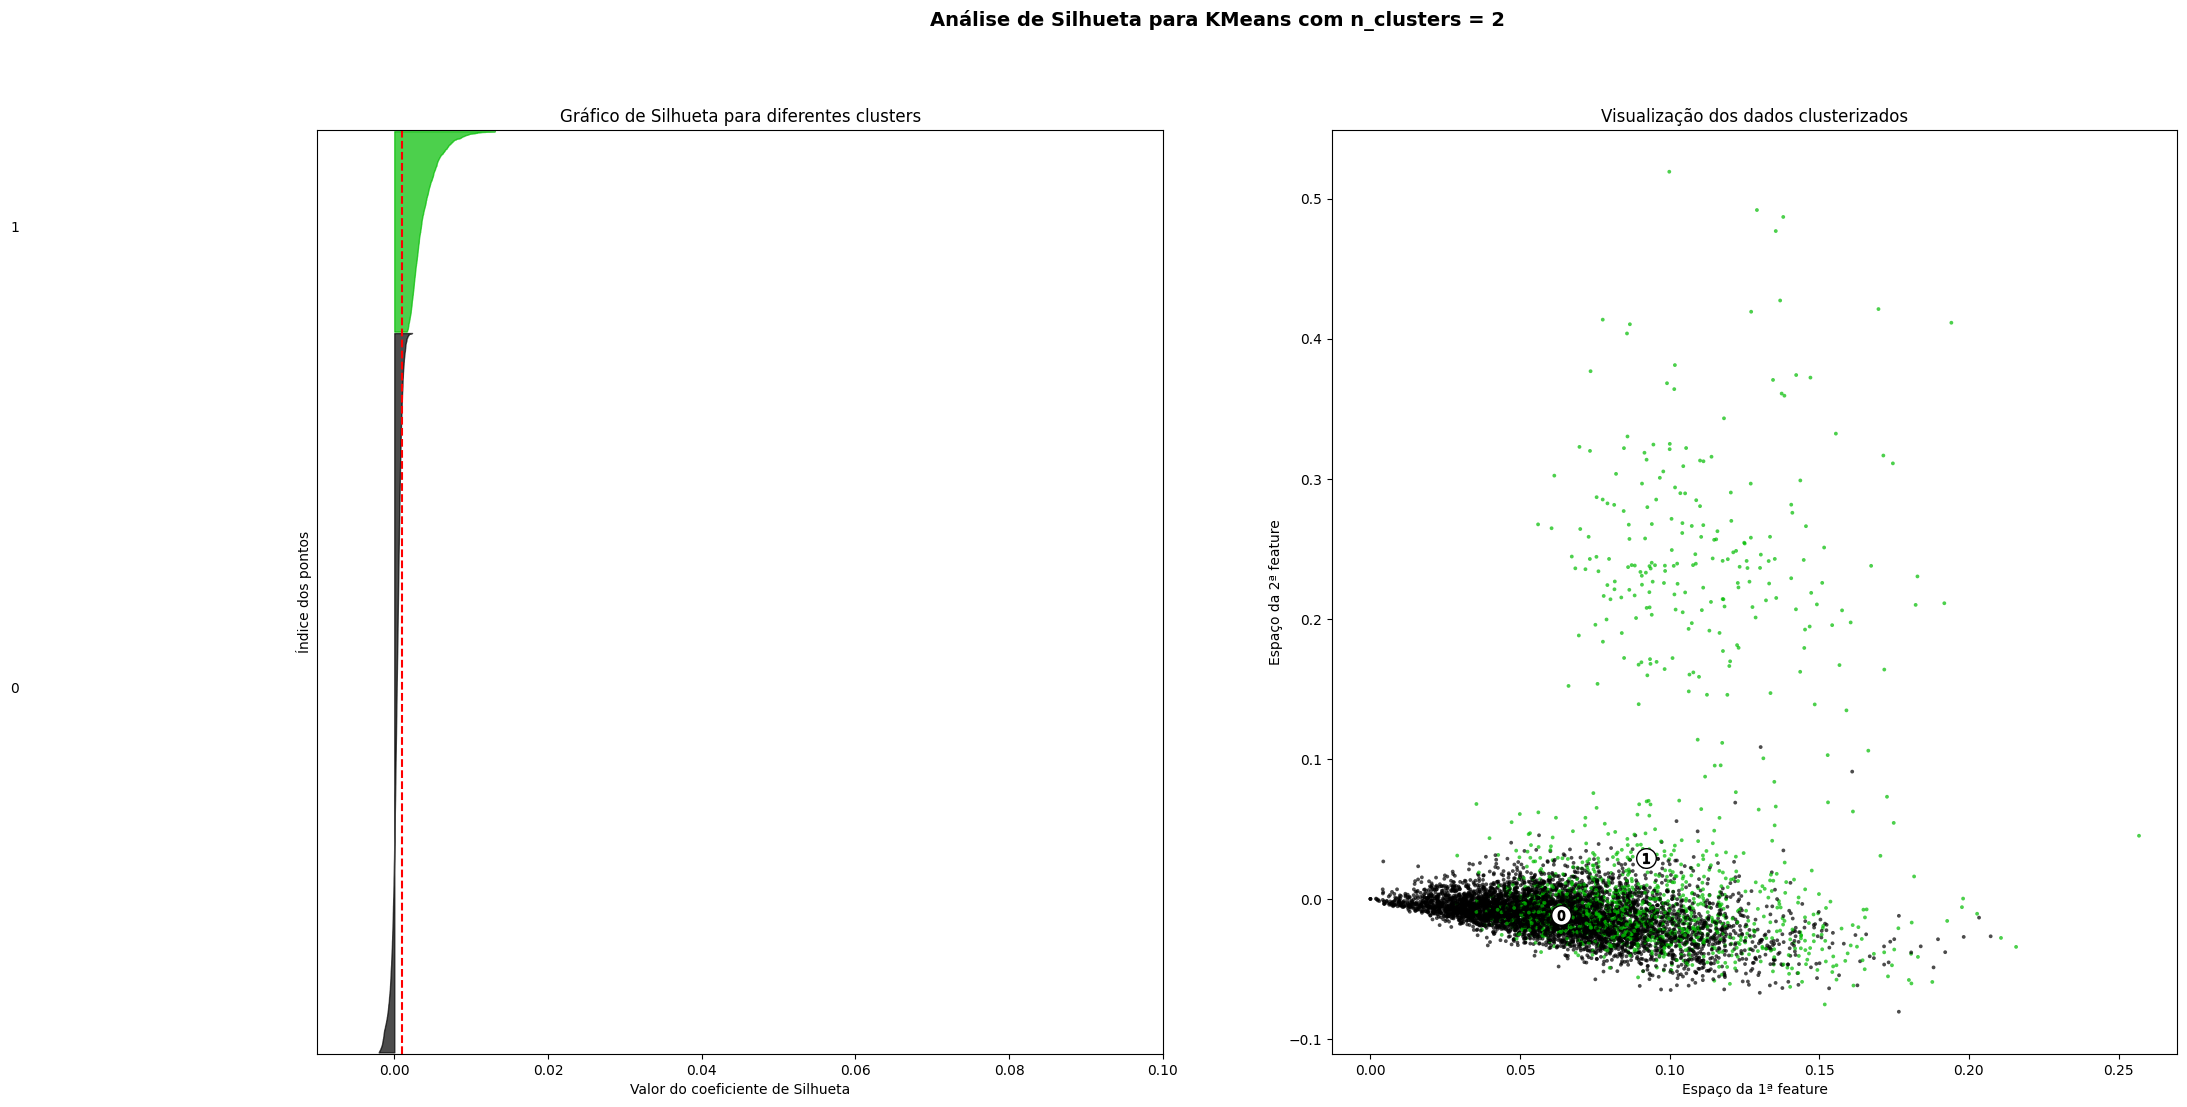

Para n_clusters = 3 a silhueta média é: 0.0014343398082894254


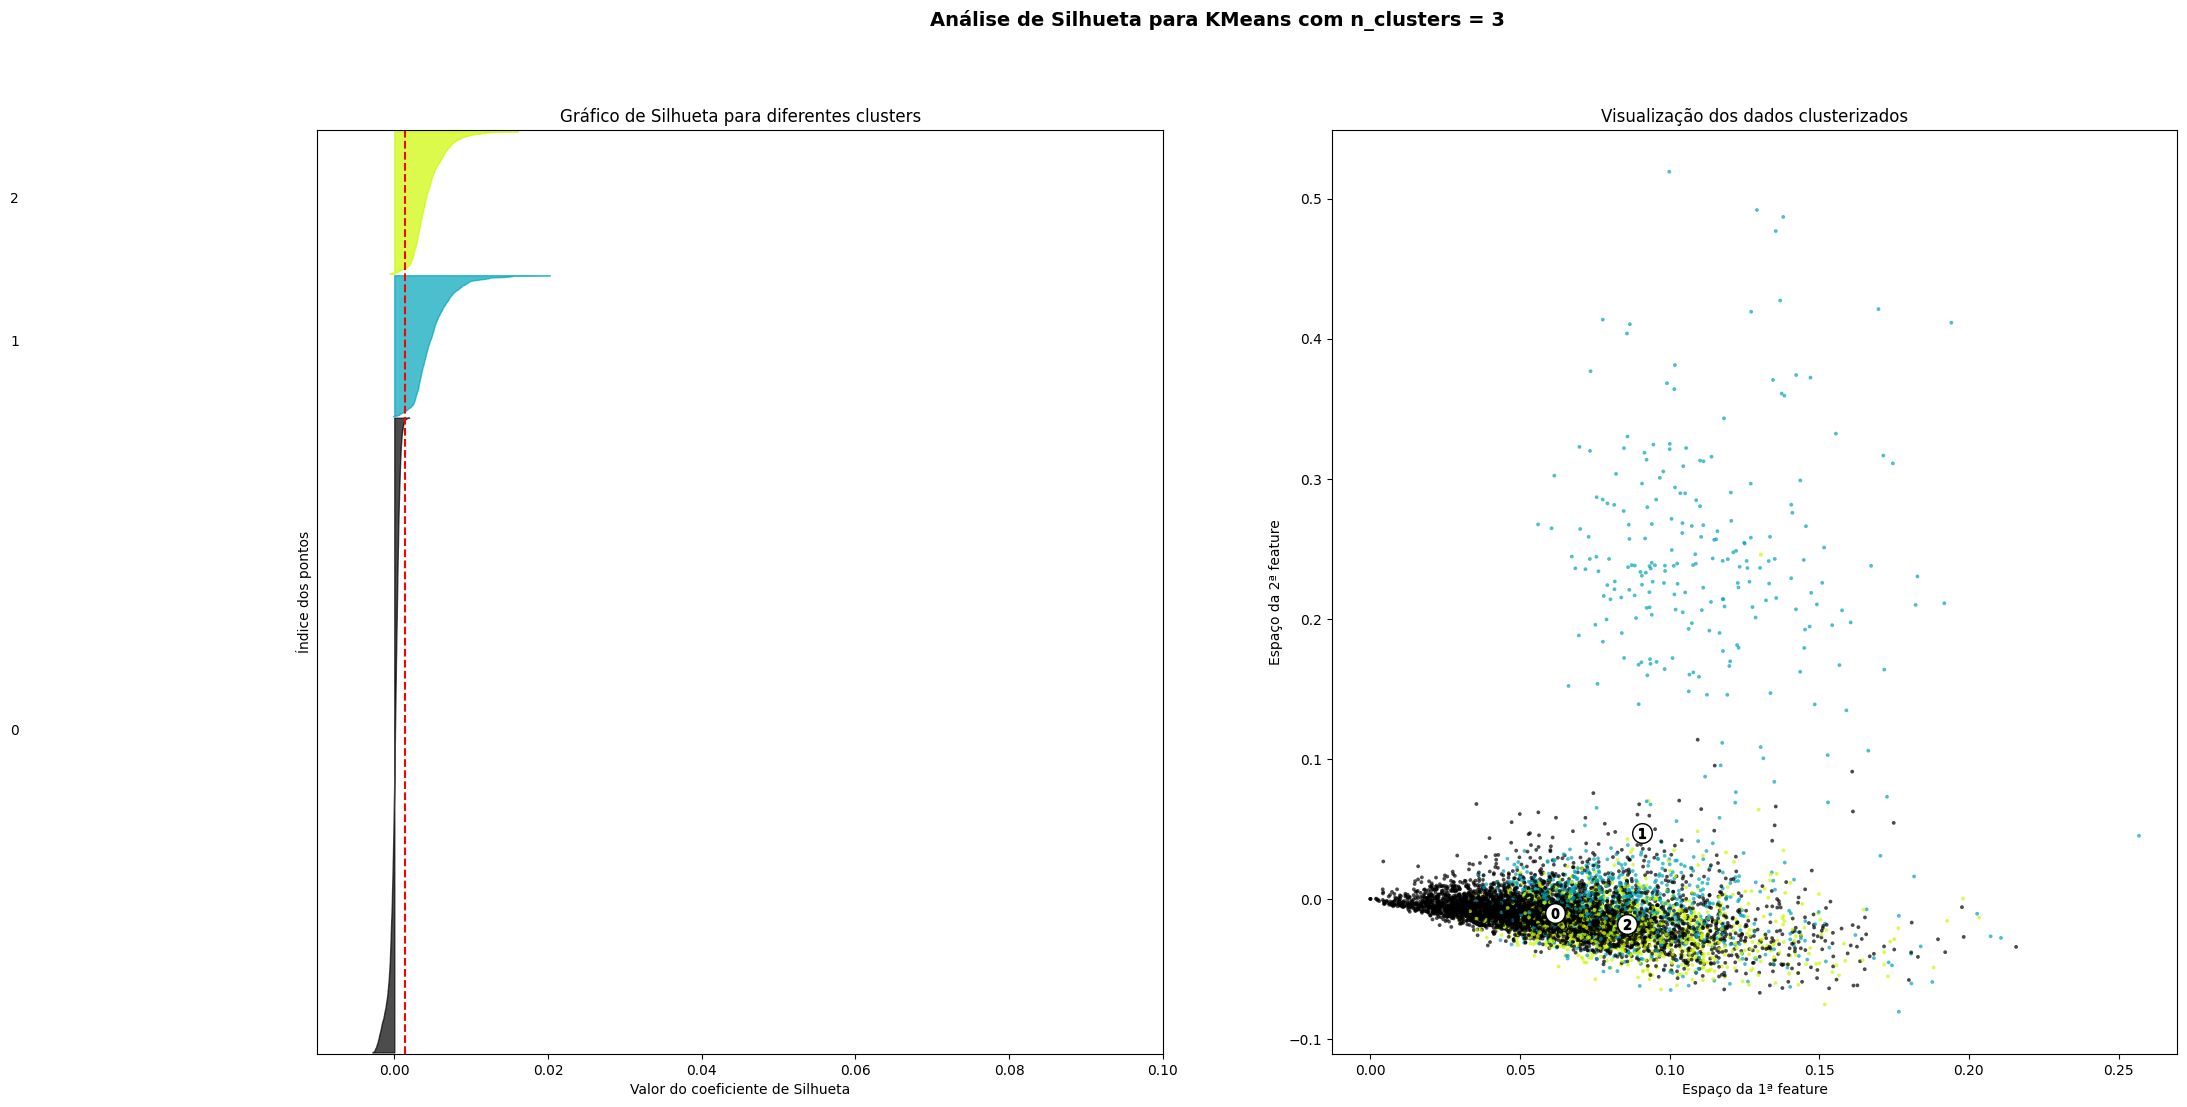

Para n_clusters = 4 a silhueta média é: 0.0019144569826799935


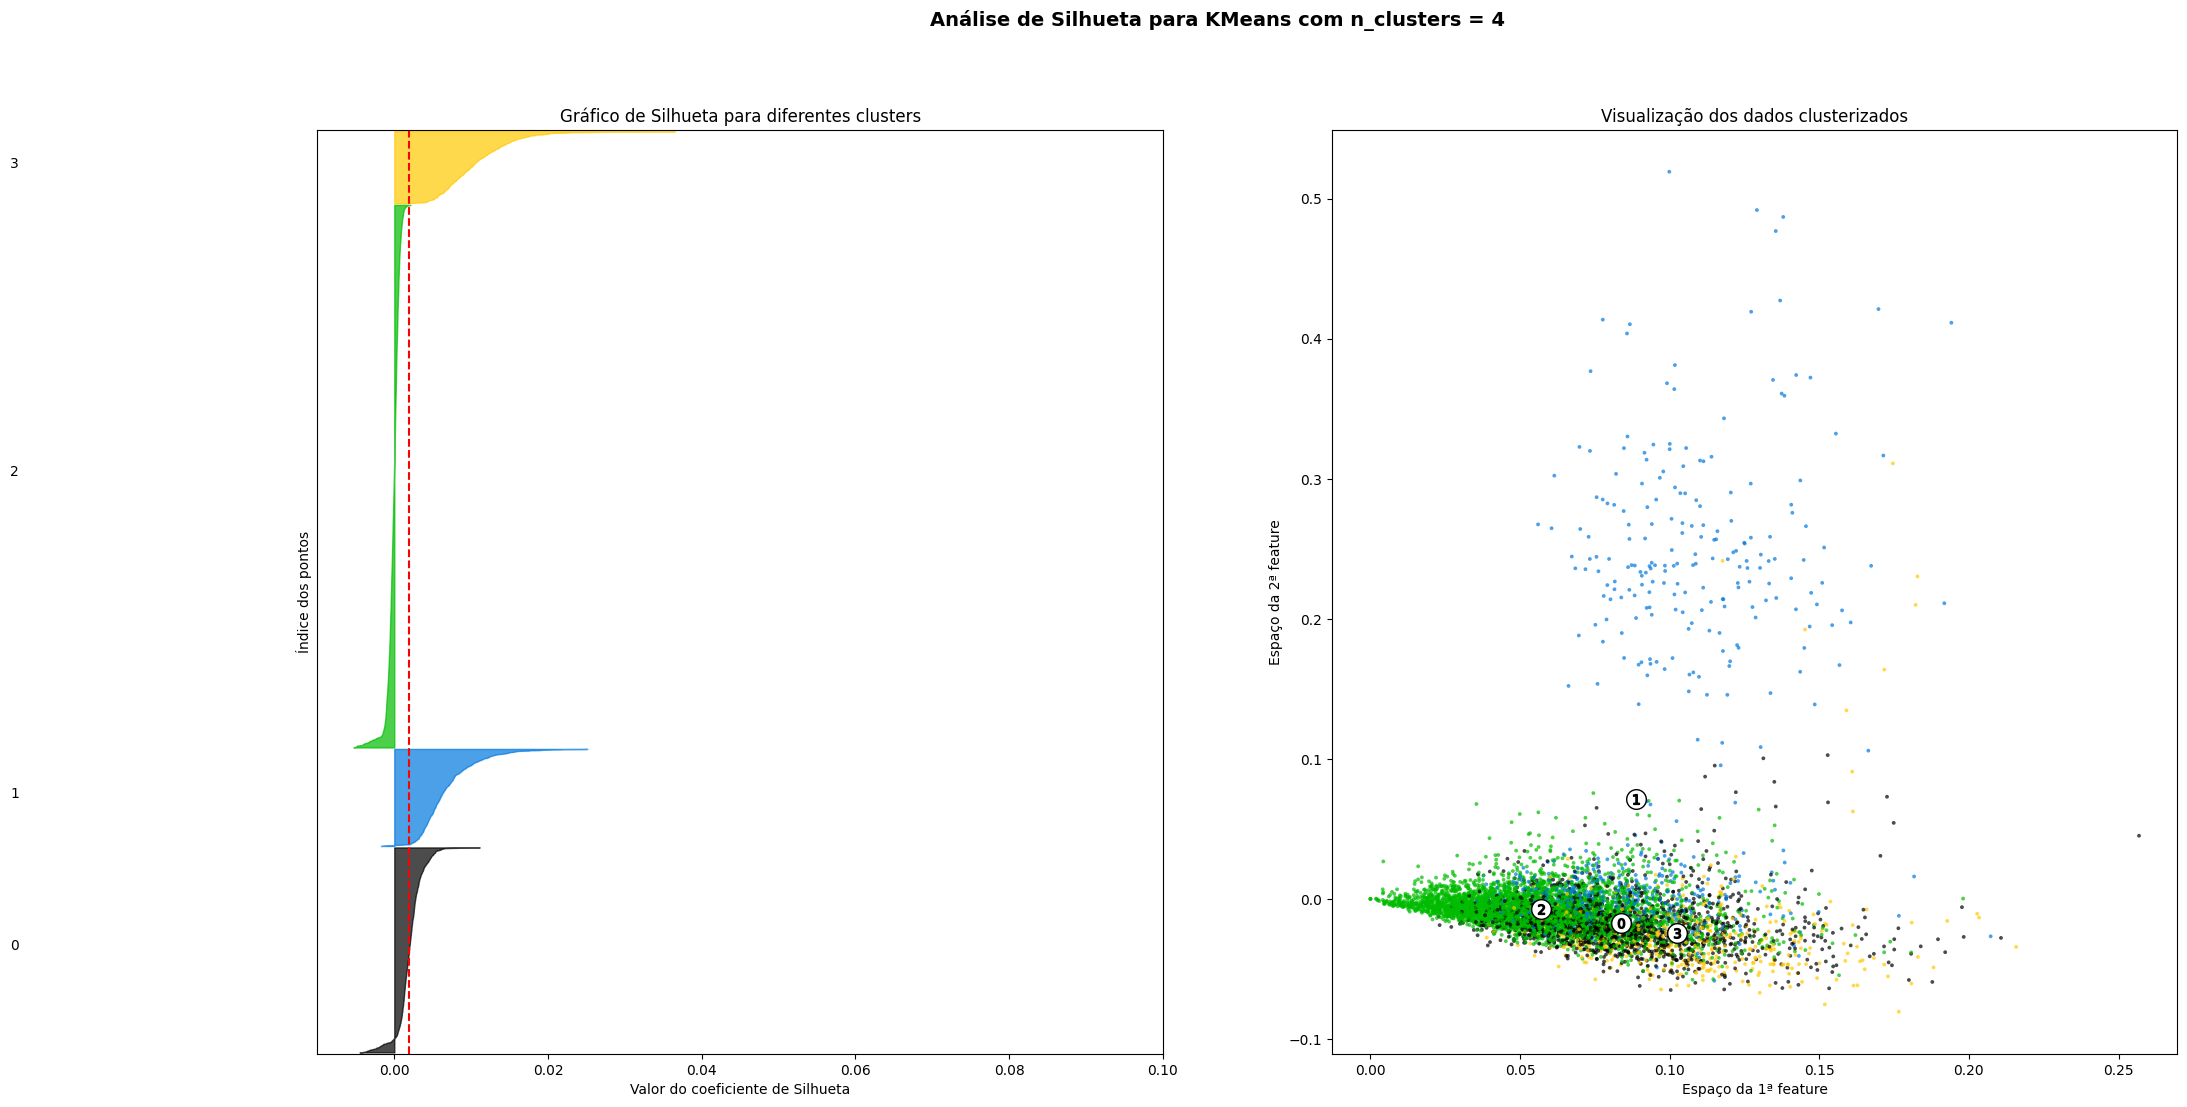

Para n_clusters = 5 a silhueta média é: 0.002164034827843218


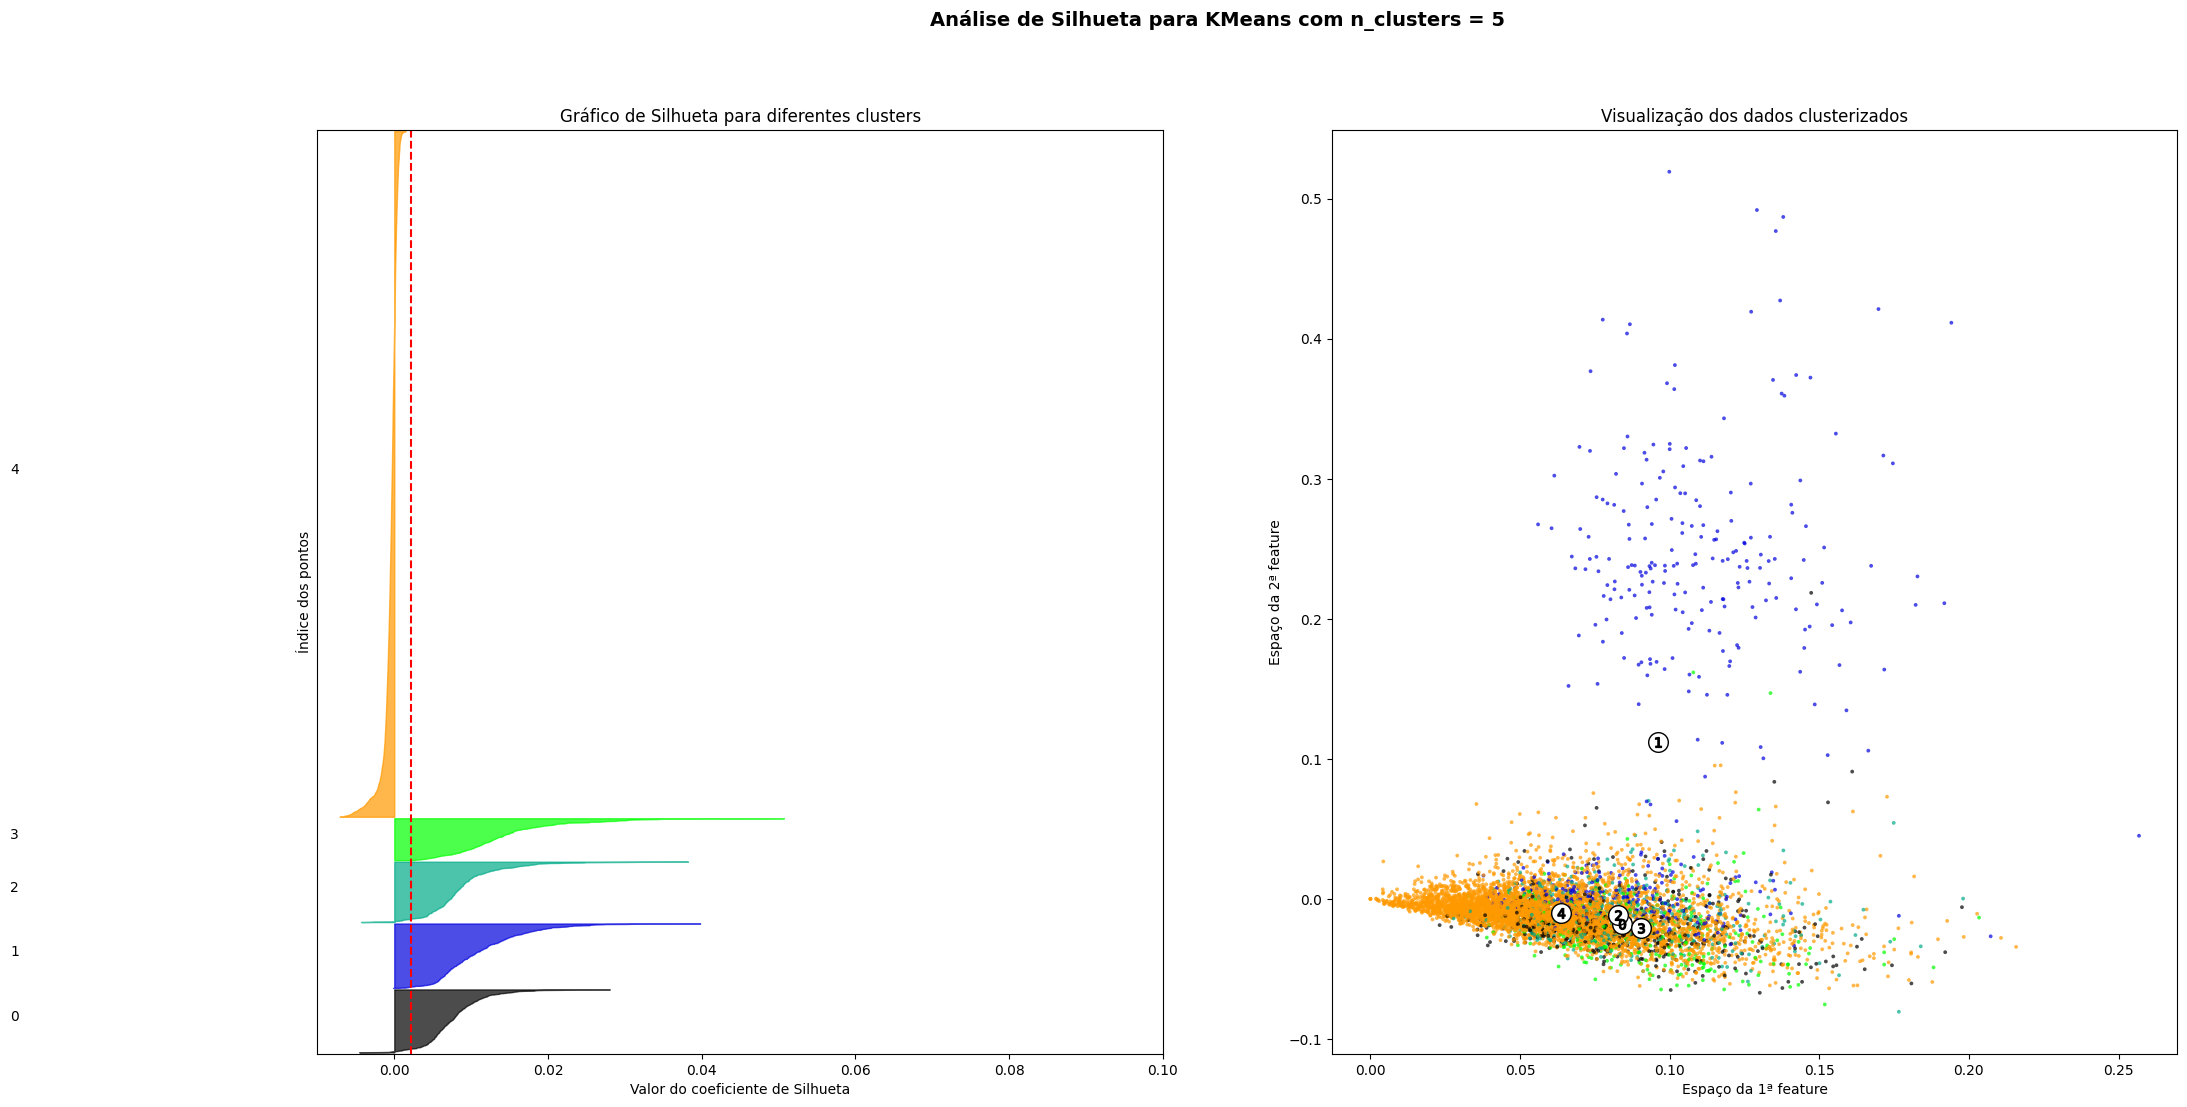

Para n_clusters = 6 a silhueta média é: 0.0026636597810235836


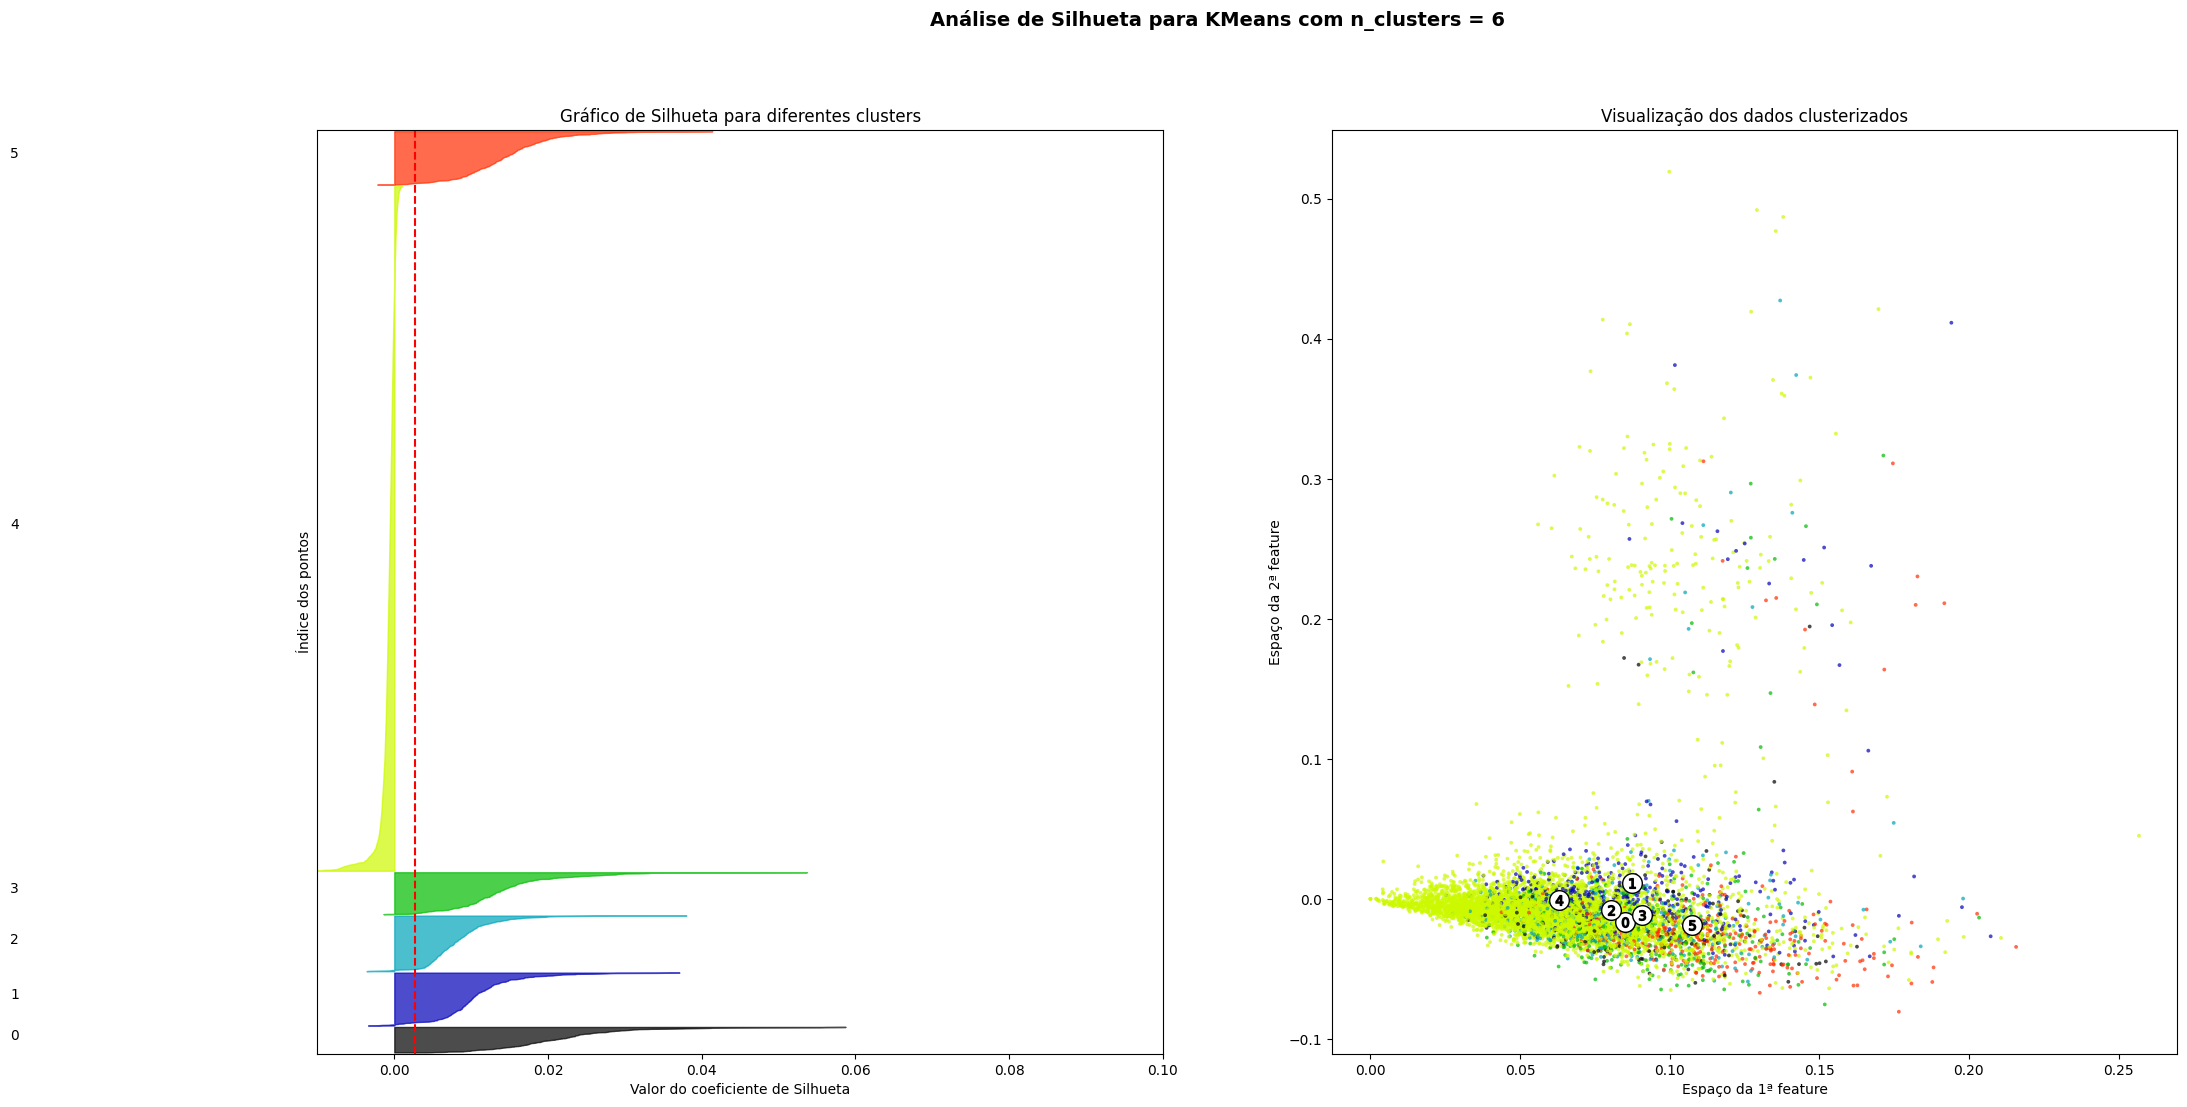

Para n_clusters = 7 a silhueta média é: 0.002994505712835033


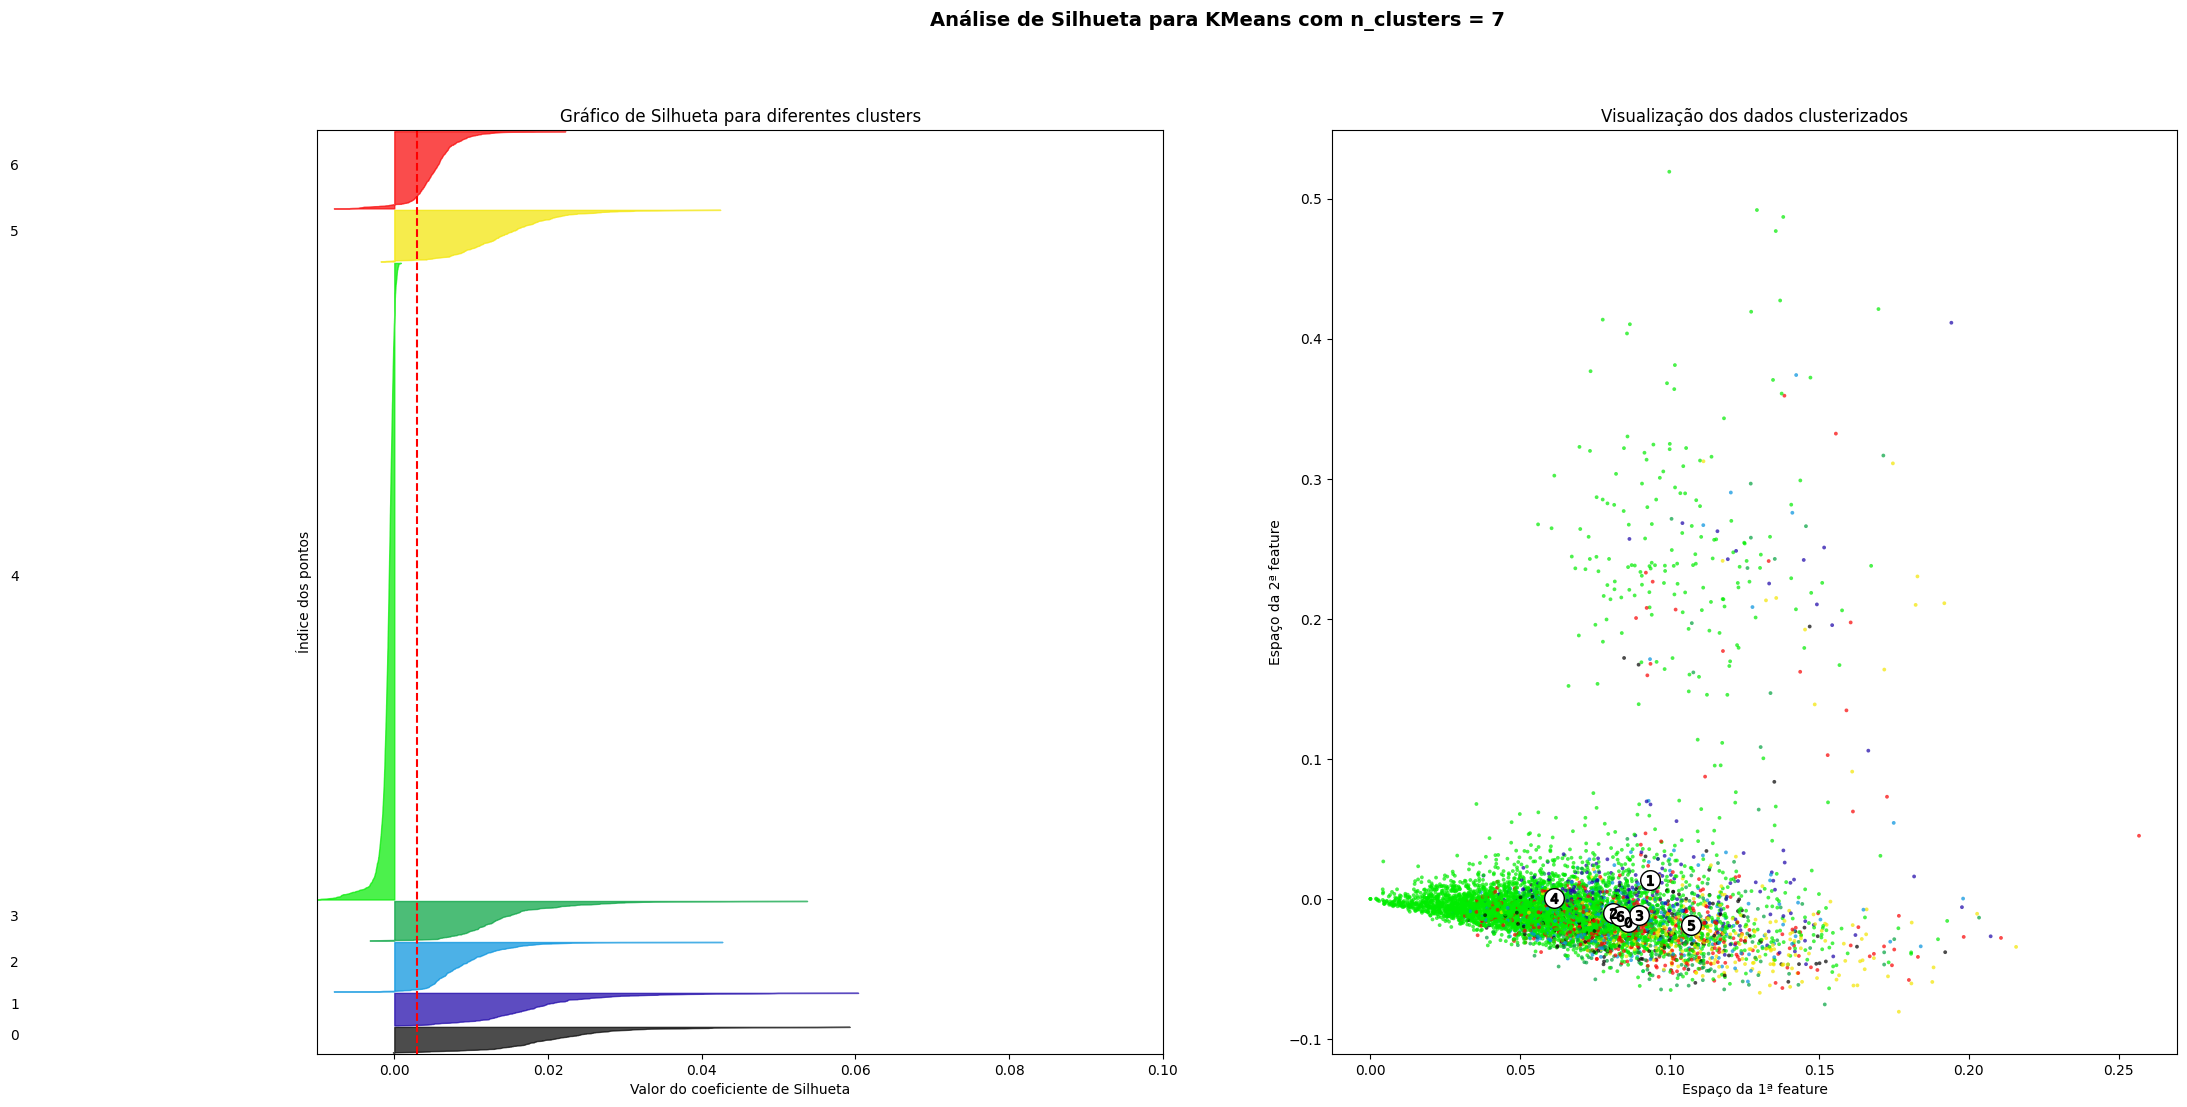

Para n_clusters = 8 a silhueta média é: 0.0037317687186187044


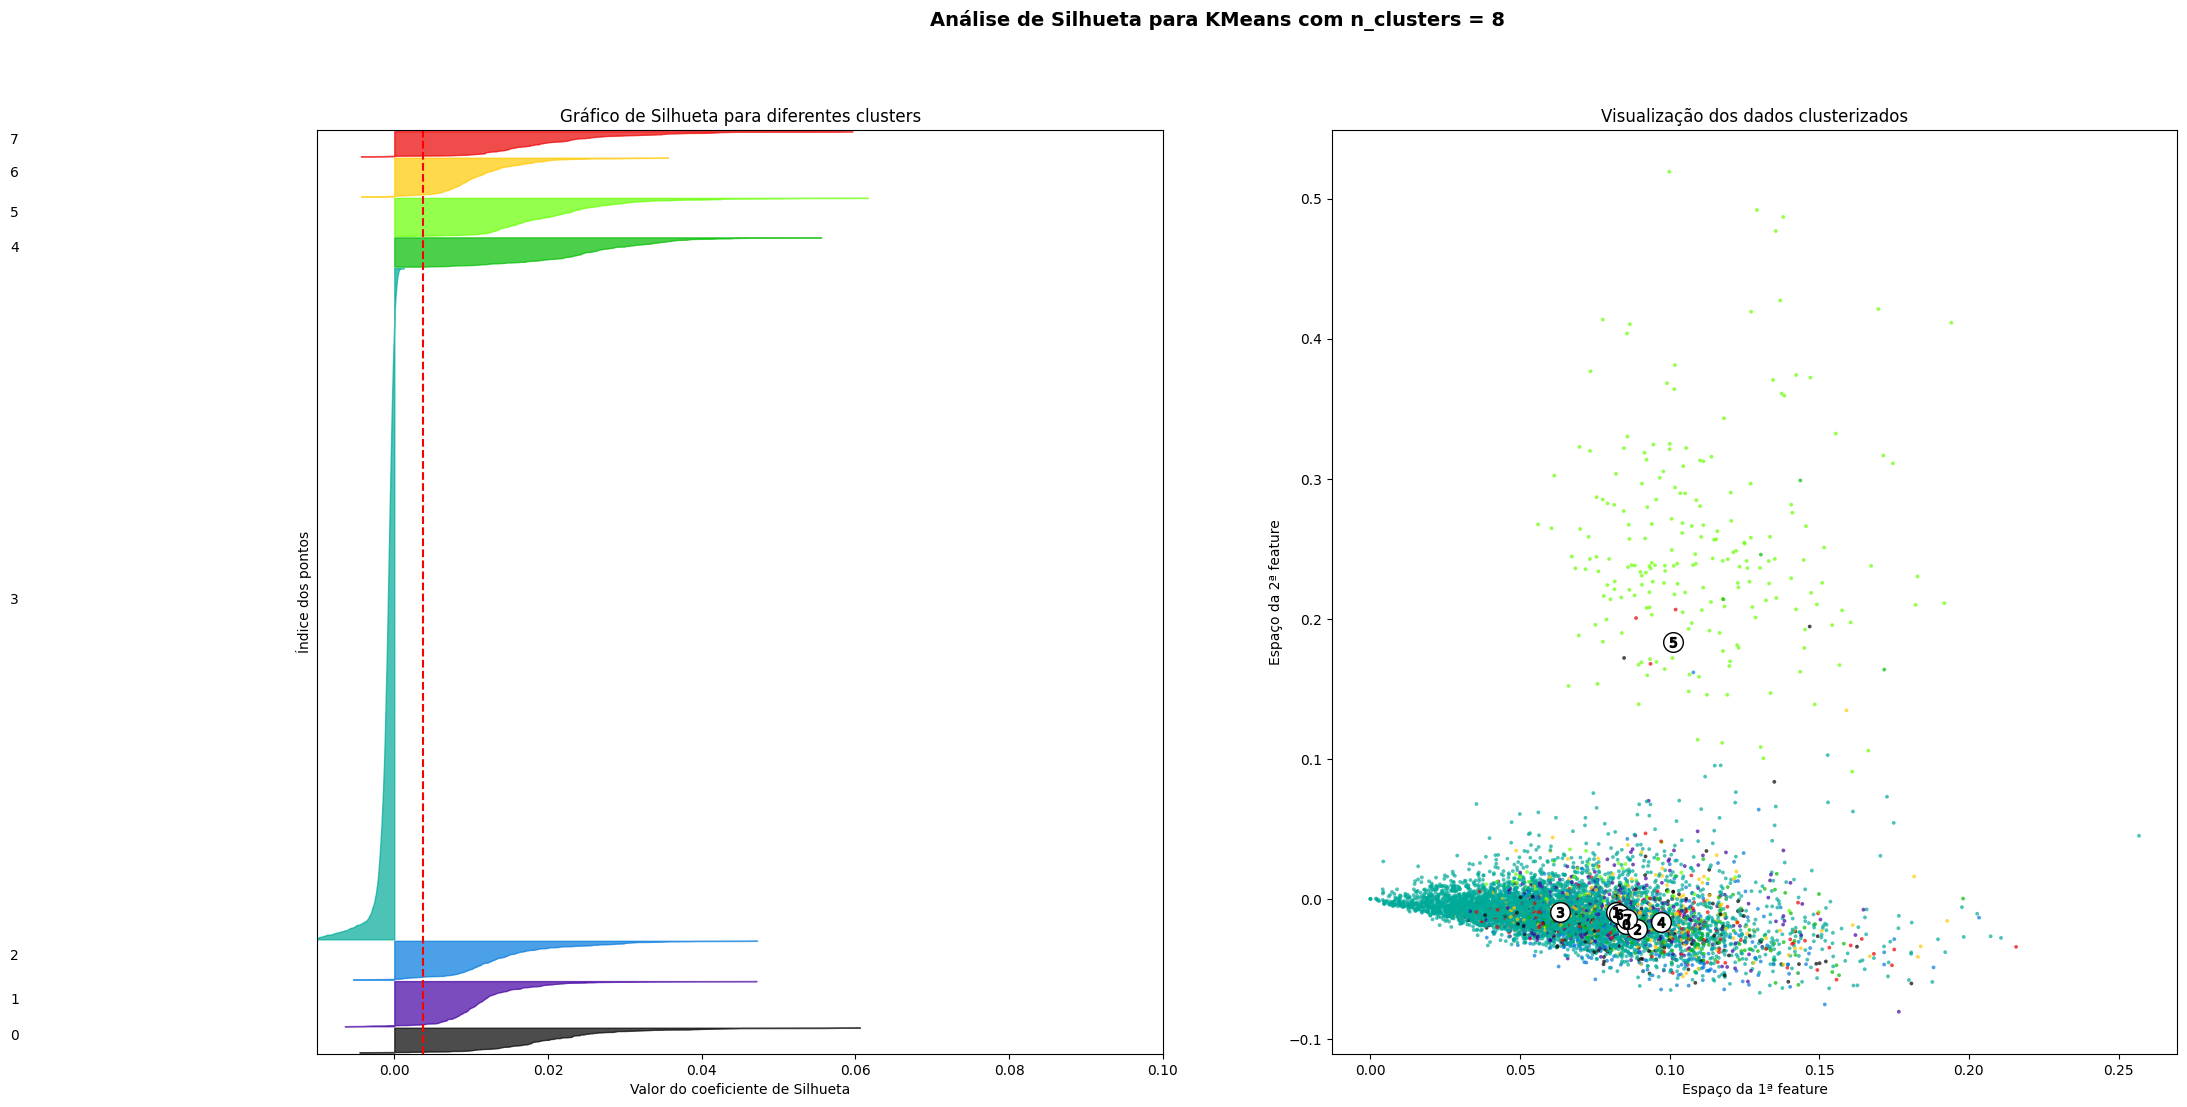

Para n_clusters = 9 a silhueta média é: 0.0040611094888834


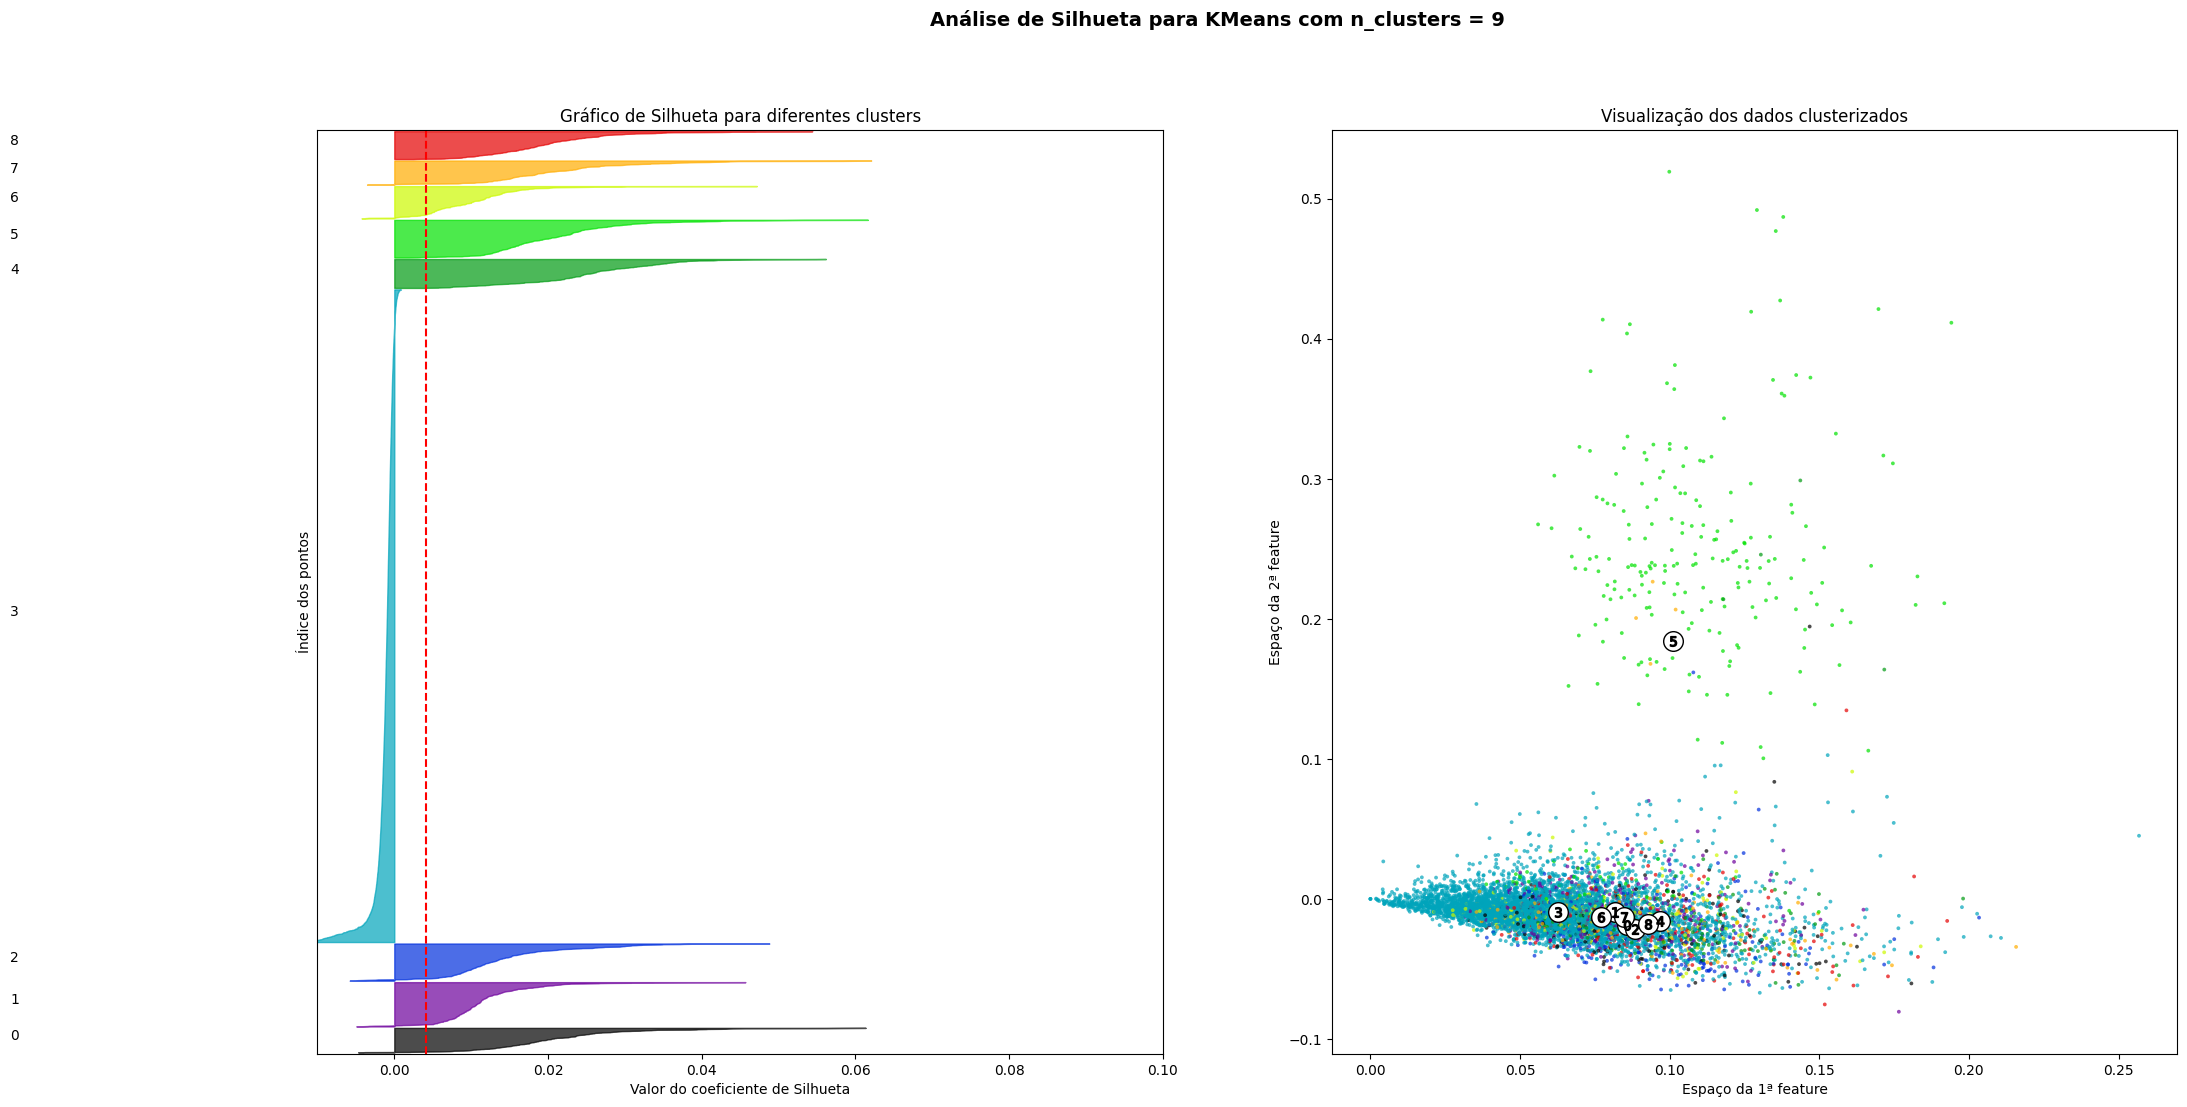

Para n_clusters = 10 a silhueta média é: 0.004486359458740131


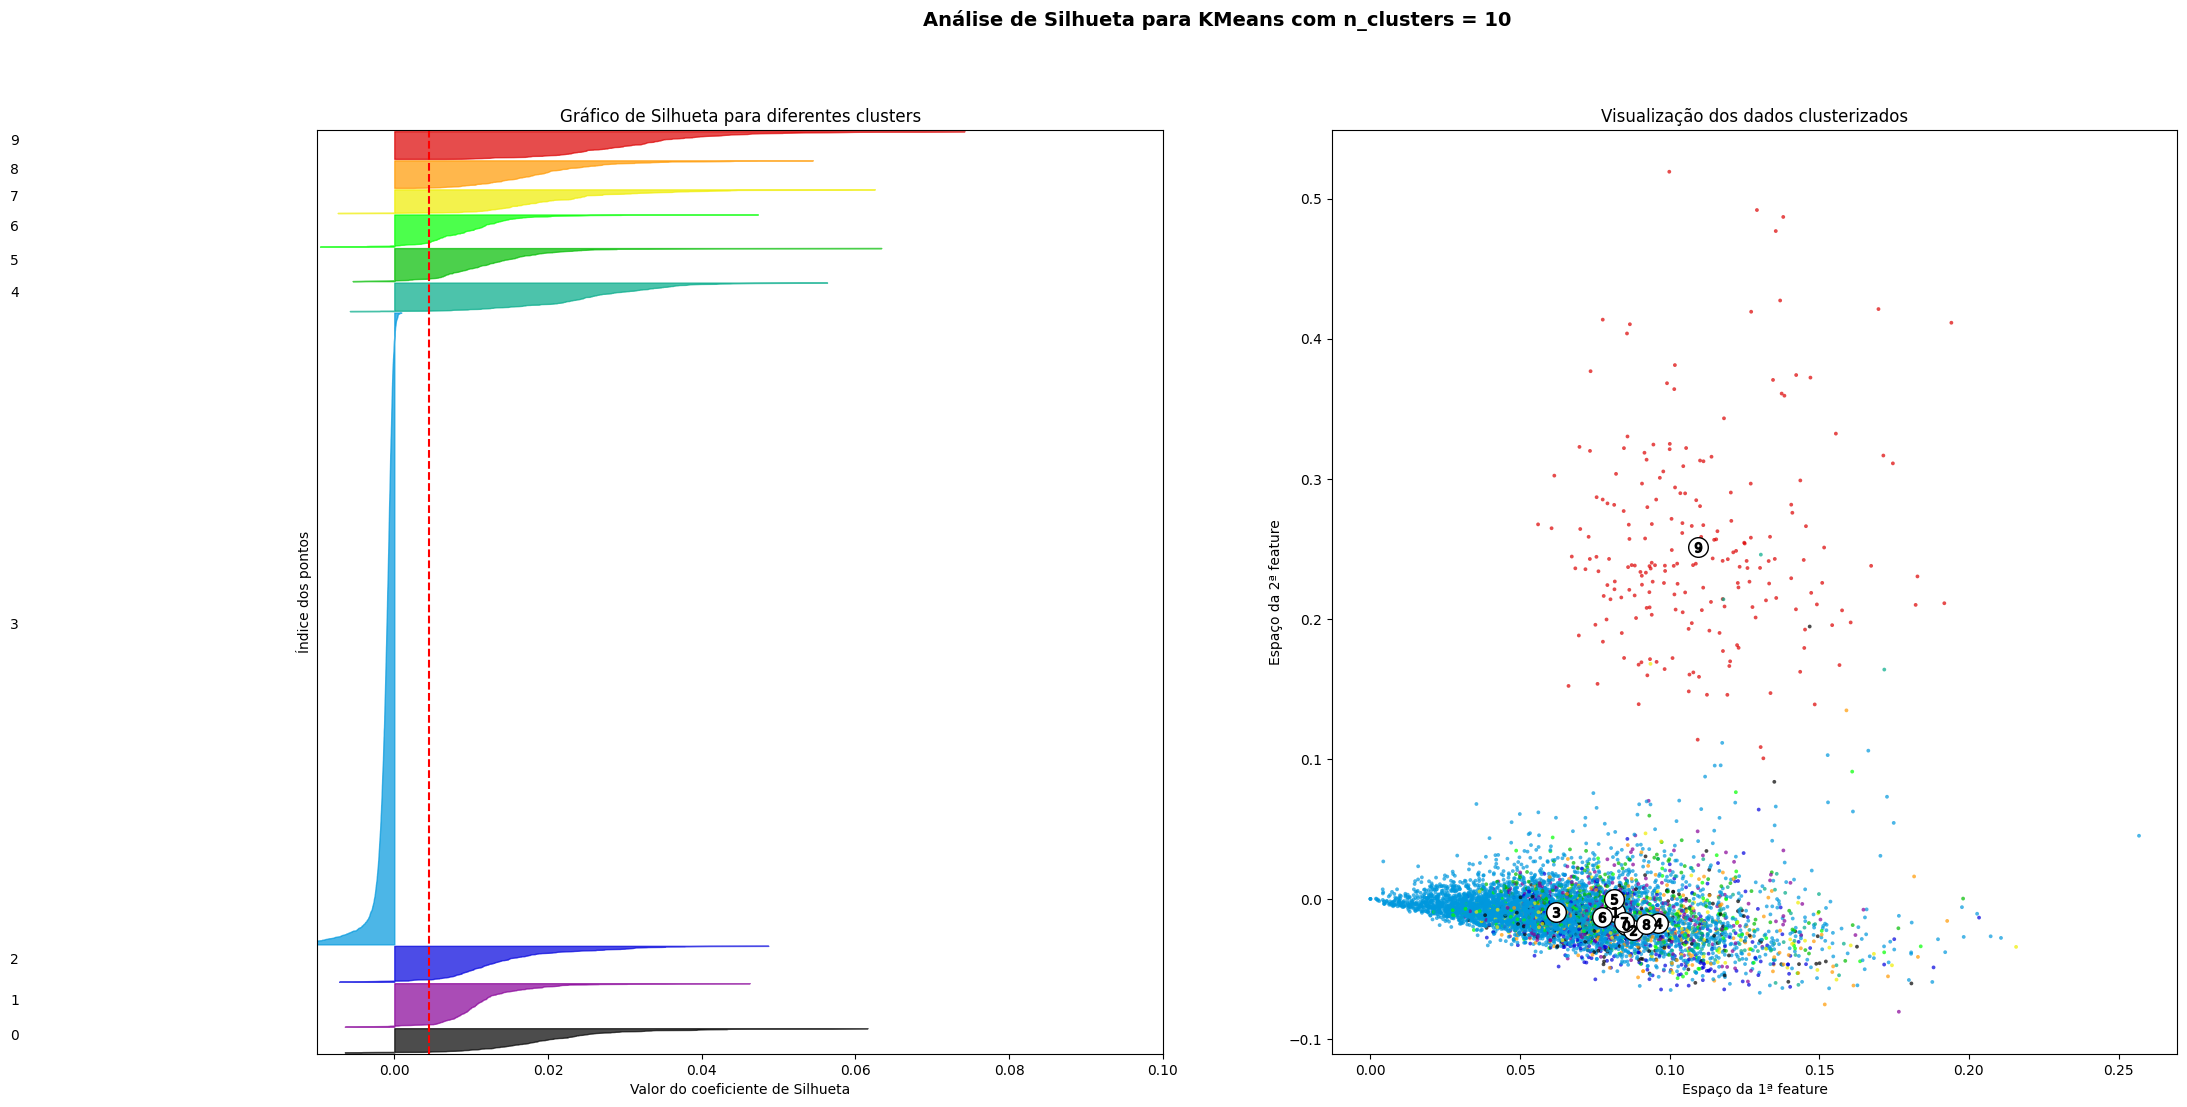

Para n_clusters = 11 a silhueta média é: 0.004794487503125038


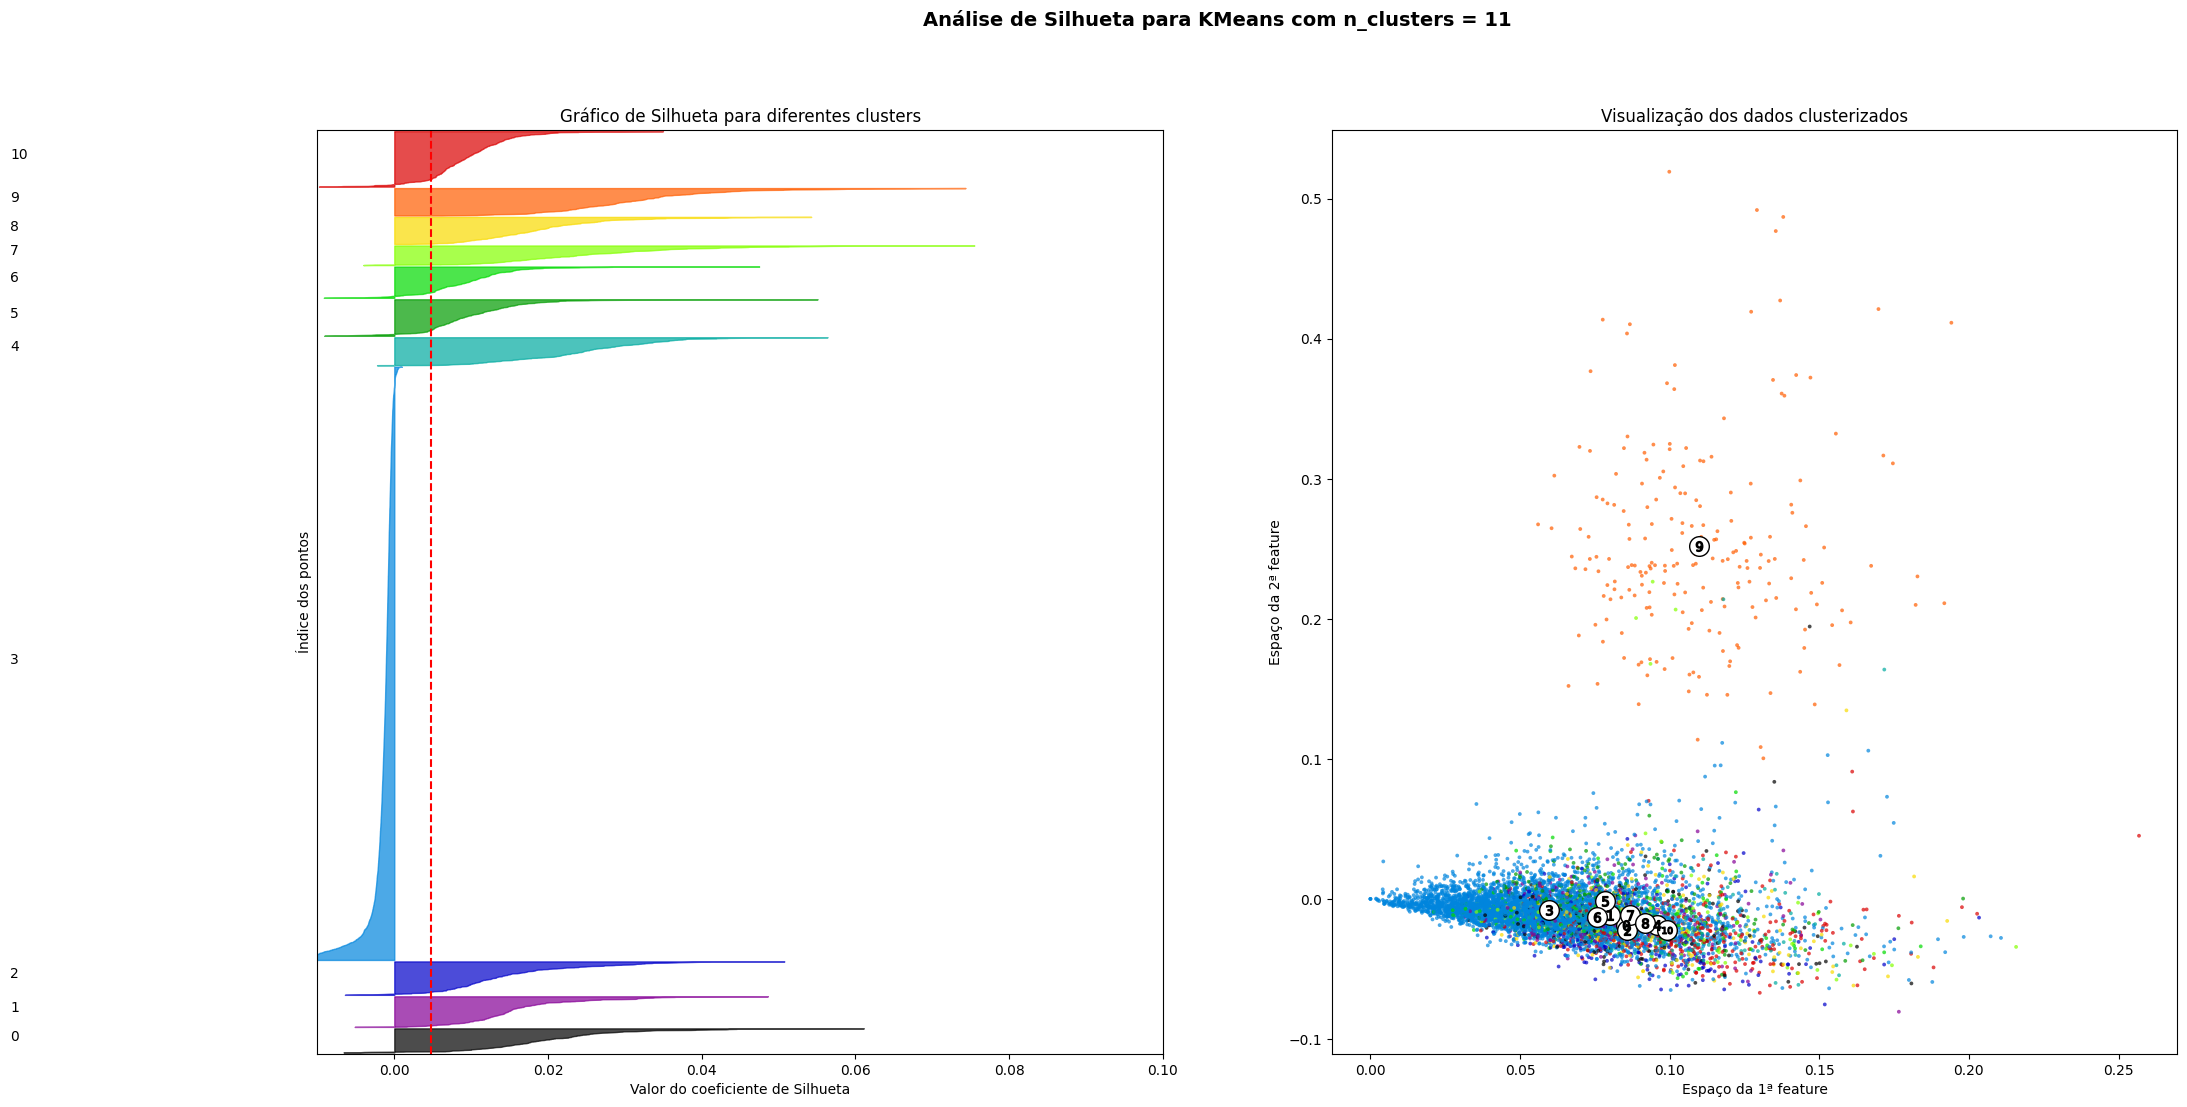

Para n_clusters = 12 a silhueta média é: 0.0049763147626108225


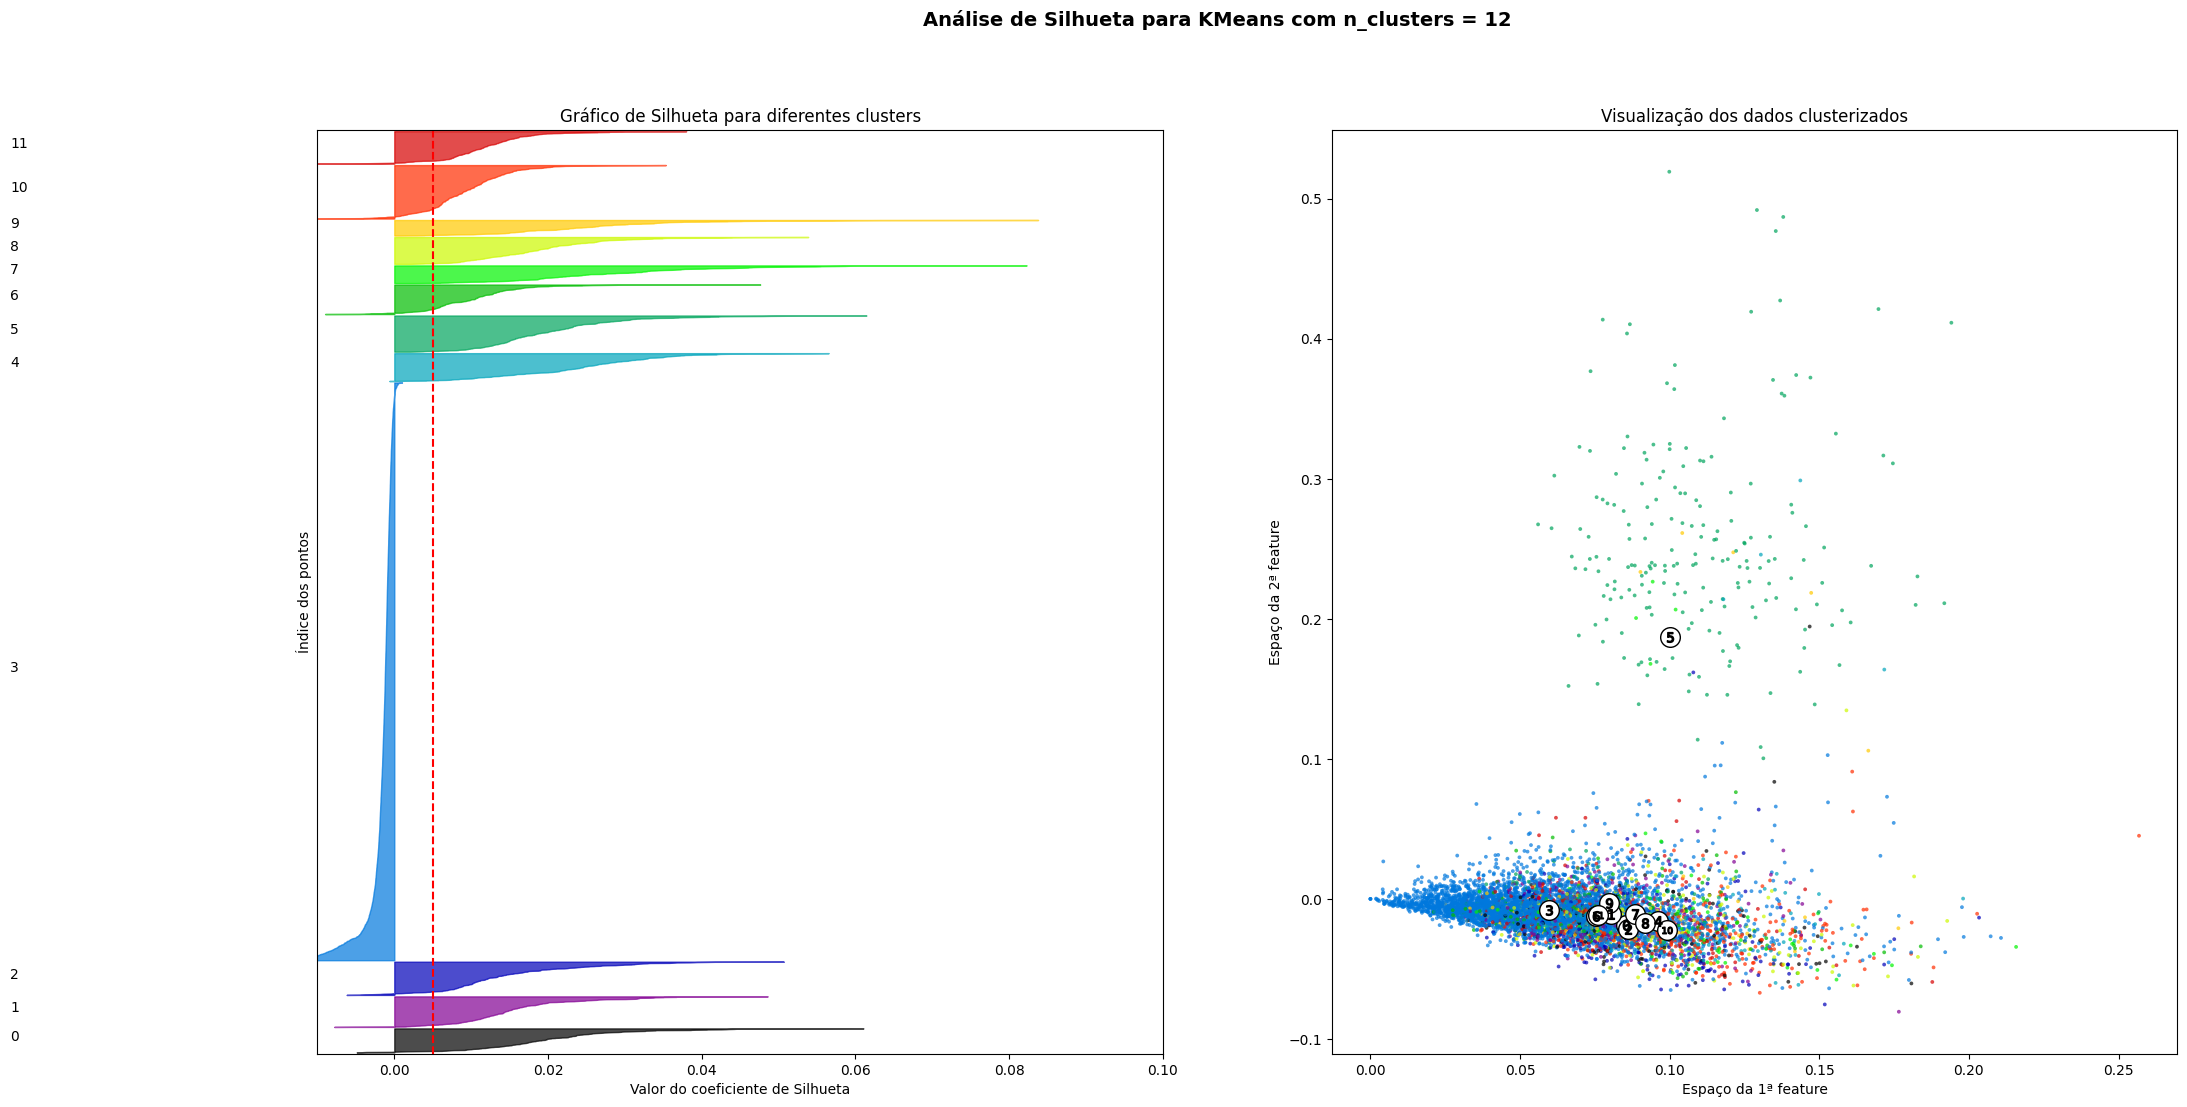

Para n_clusters = 13 a silhueta média é: 0.005429205173295776


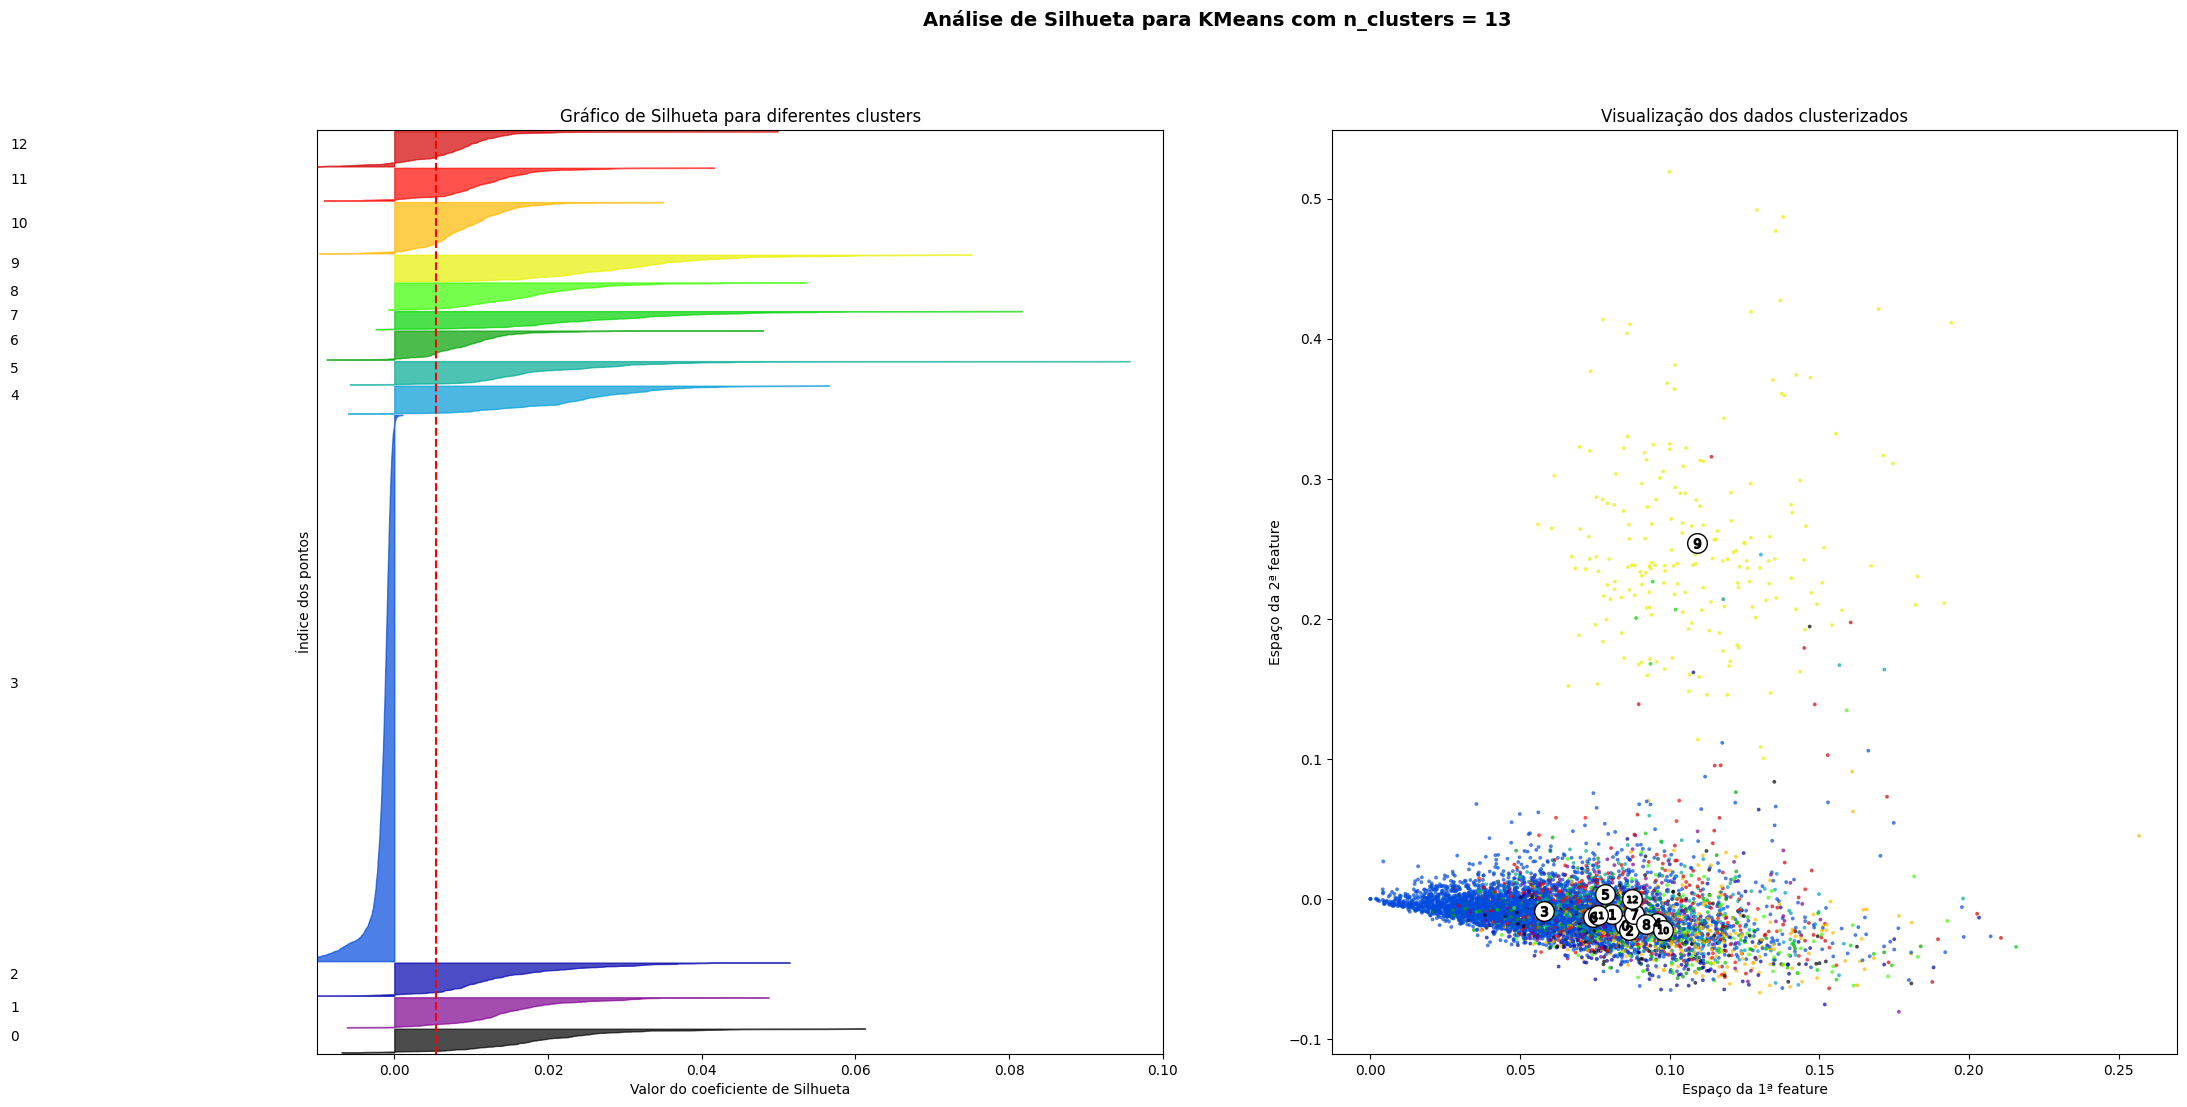

Para n_clusters = 14 a silhueta média é: 0.005635811954164312


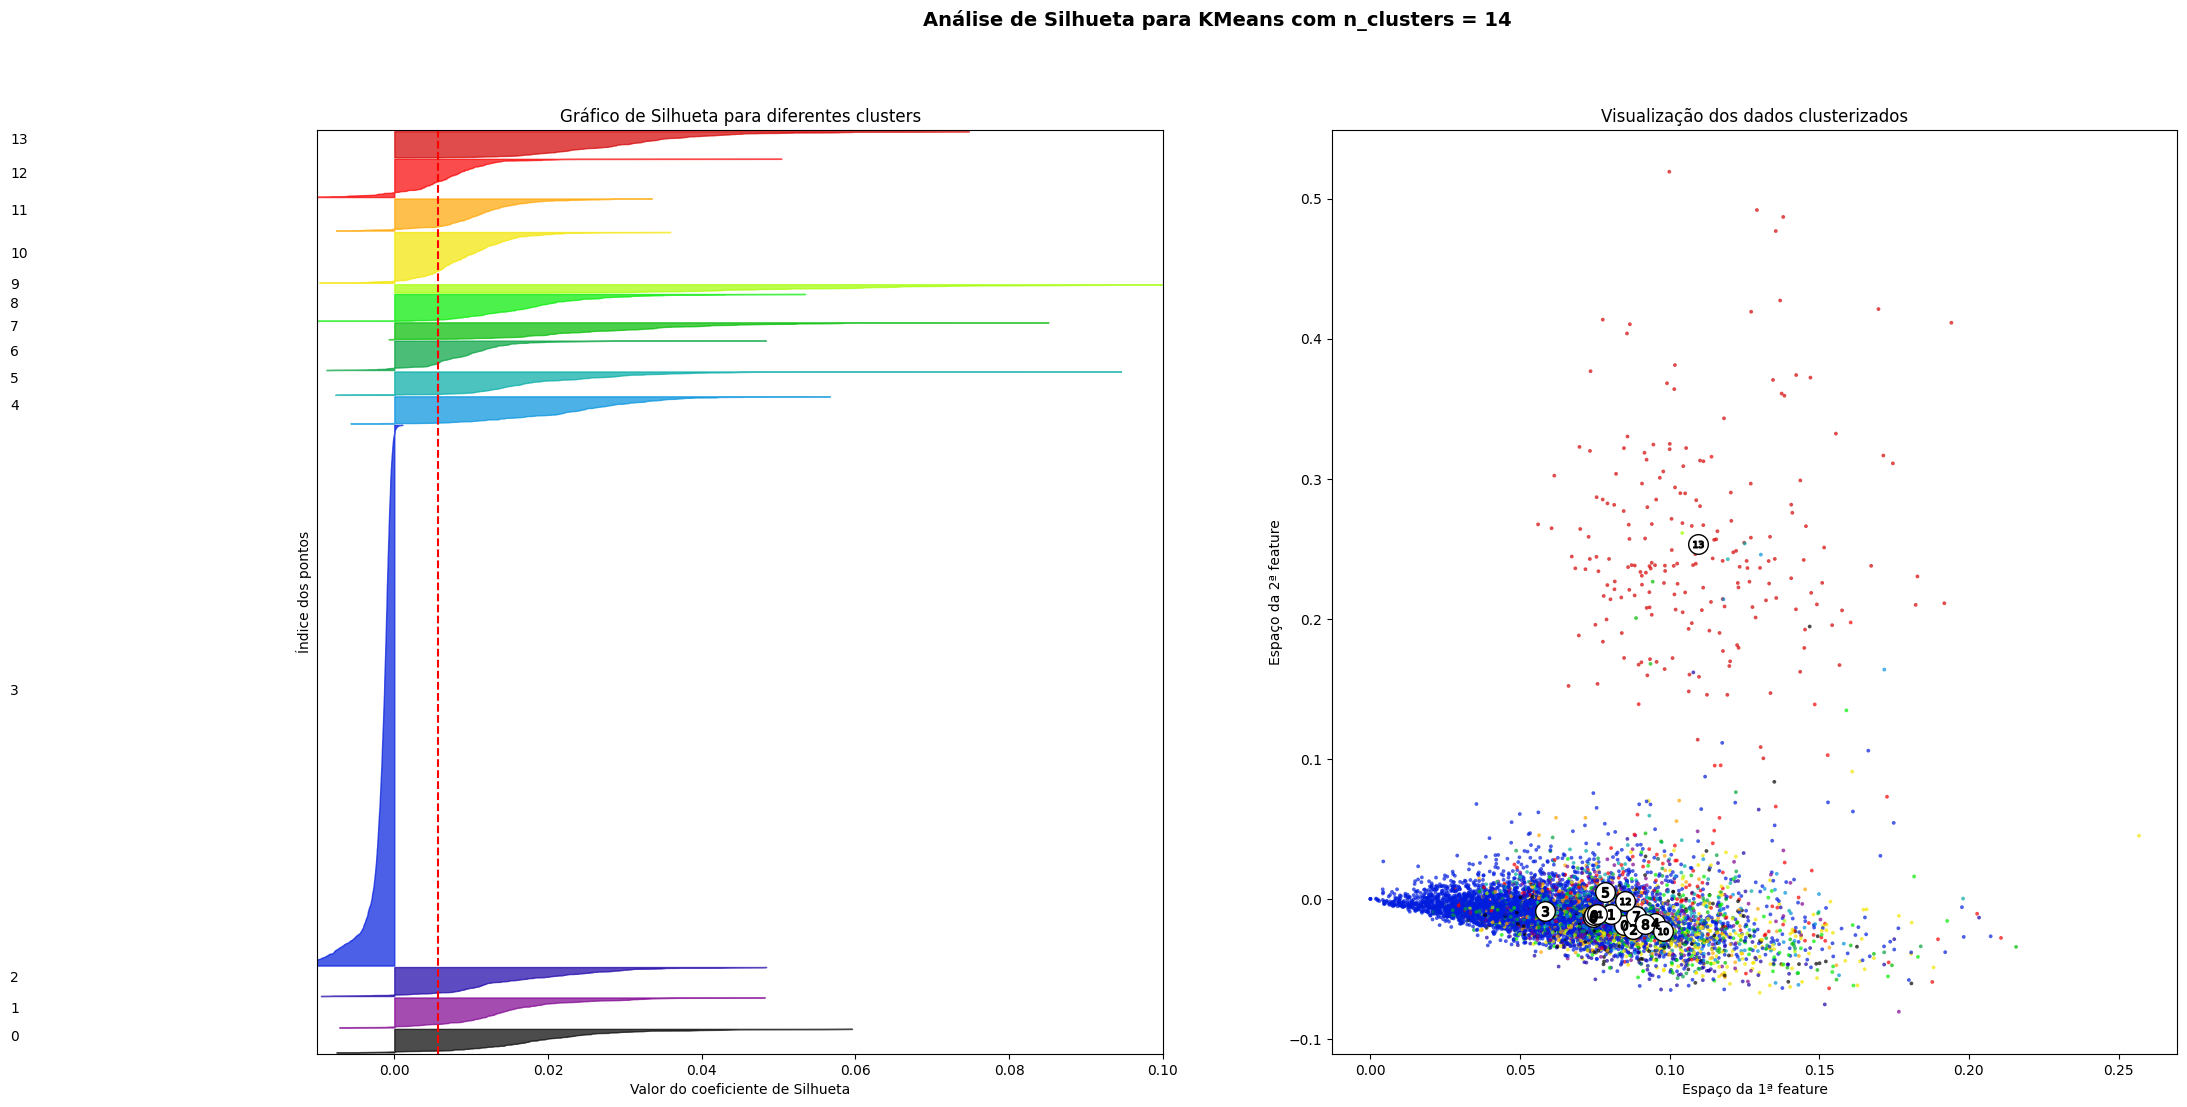

Para n_clusters = 15 a silhueta média é: 0.005701777331420418


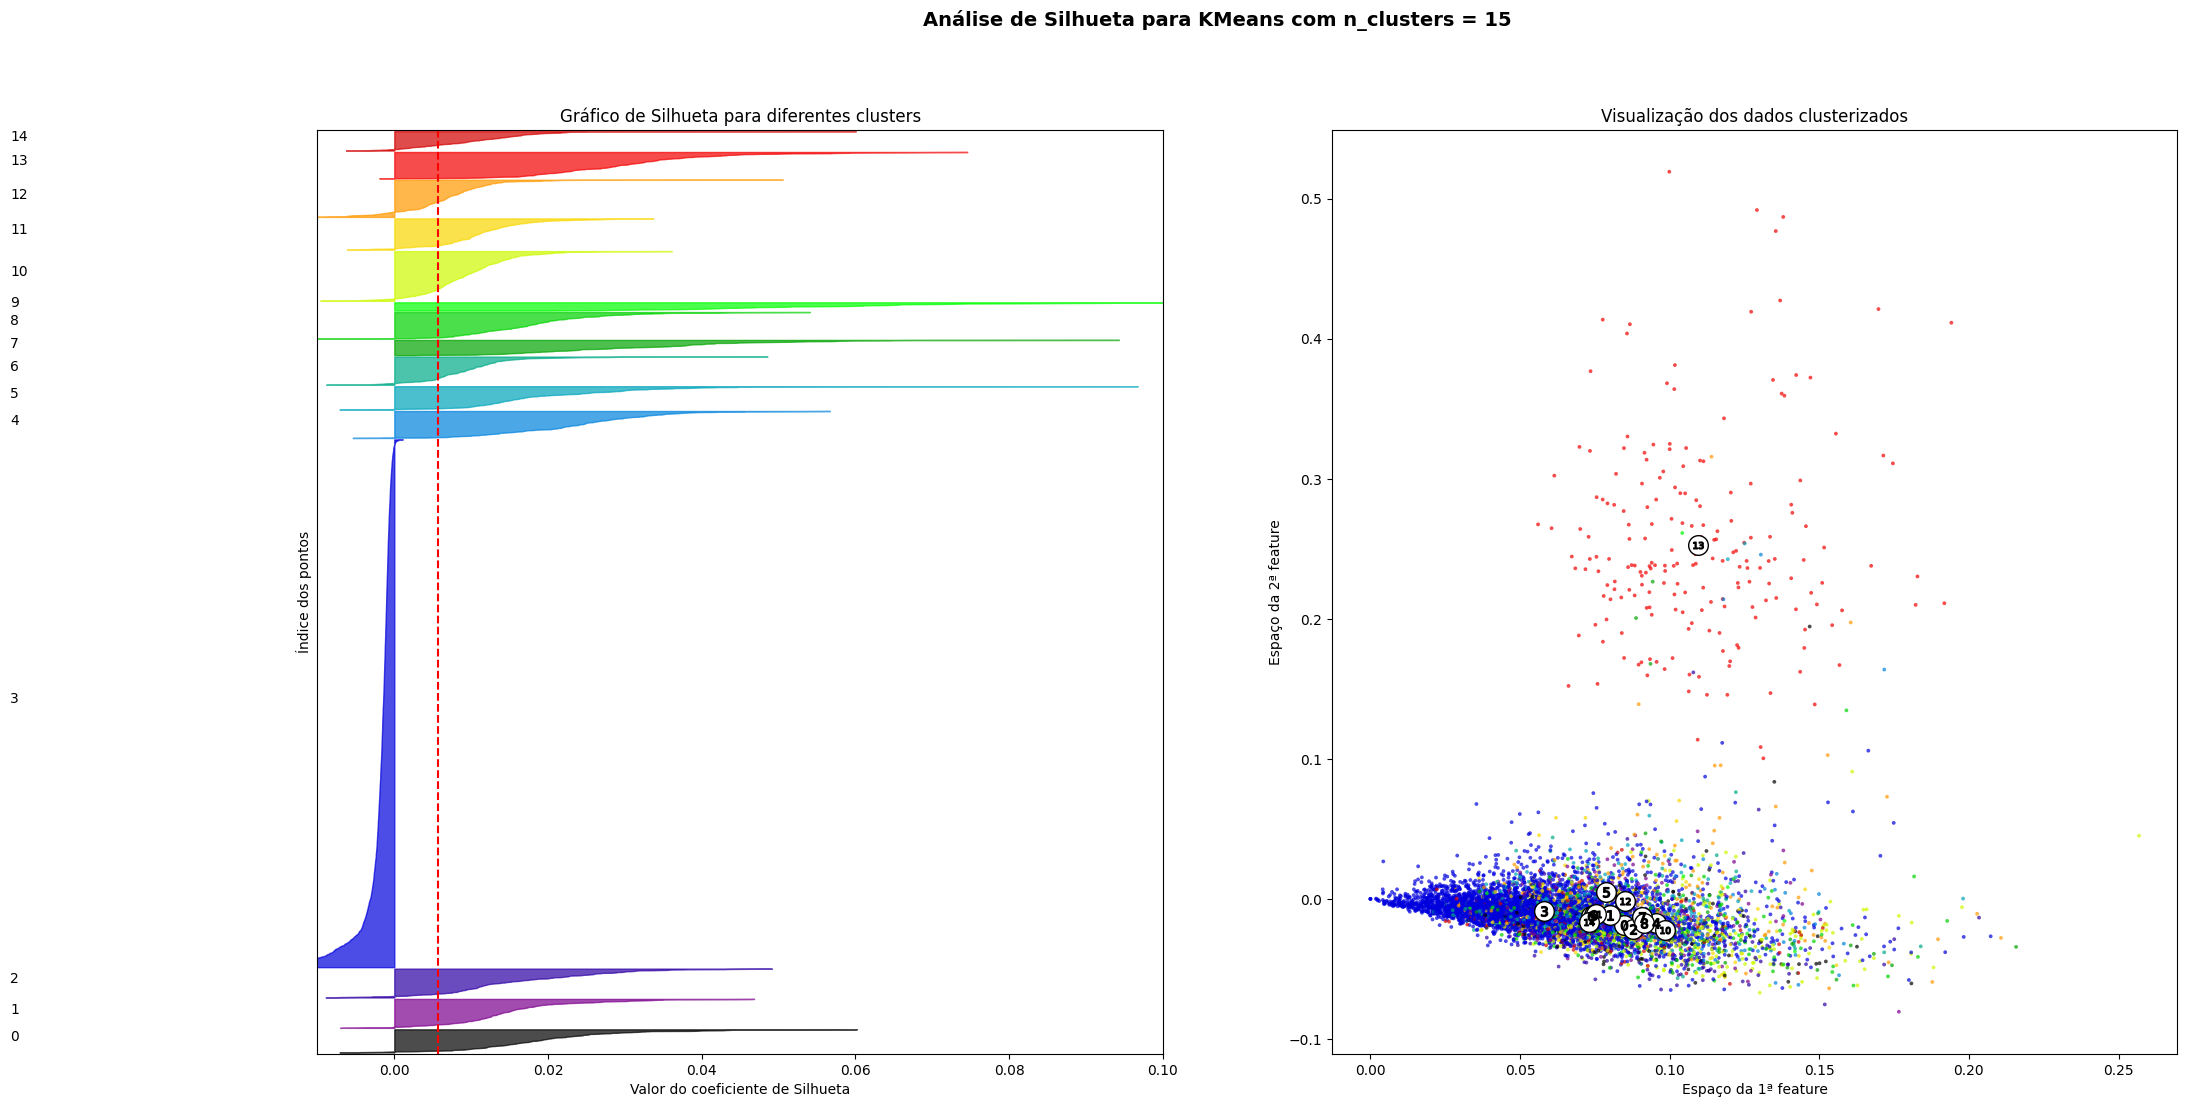

In [ ]:
# _, X_tfidf_dominant = build_tf_idf(df_cluster_dominant['processed_sinopse'])
# n_components_dominant = select_n_components(X_tfidf_dominant, threshold=0.8)
# _, X_lsa_dominant, _ = perform_lsa(X_tfidf_dominant, n_components_dominant)
#silhouette_analysis_generic(X_lsa_dominant, range(2, 16), KMeans, random_state=42, n_init=10, max_iter=300, init='k-means++')


E sim os dados estão muito misturados.

Voltando a análise principal com kmeans, vamos conferir quais palavras mais influenciam cada cluster

In [ ]:
def print_top_terms(kmeans, lsa, vectorizer, n_clusters: int, n_terms: int = 10):
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    top_terms_by_cluster = {}
    for i in range(n_clusters):
        print(f"Cluster {i}: ", end="")
        cluster_terms = []
        for ind in order_centroids[i, :n_terms]:
            term = terms[ind]
            print(f"{term} ", end="")
            cluster_terms.append(term)
        print()
        top_terms_by_cluster[i] = cluster_terms

    return order_centroids, top_terms_by_cluster

In [ ]:
order_centroids, top_terms_by_cluster = print_top_terms(kmeans, lsa, vectorizer, n_clusters=n_clusters, n_terms=10)

In [ ]:
def plot_cluster_genres_heatmap(df: pd.DataFrame, cluster_col: str = 'cluster_kmeans', genres_col: str = 'genres') -> None:
    df_exploded = df.copy()
    df_exploded[genres_col] = df_exploded[genres_col].str.split(',')
    df_exploded = df_exploded.explode(genres_col)
    df_exploded[genres_col] = df_exploded[genres_col].str.strip()

    ct = pd.crosstab(df_exploded[cluster_col], df_exploded[genres_col], normalize='index') * 100

    fig = px.imshow(
        ct,
        labels={'x': 'Gêneros', 'y': 'Cluster', 'color': 'Percentual (%)'},
        x=ct.columns,
        y=ct.index,
        text_auto=".1f",  # Exibe os valores com 1 casa decimal
        color_continuous_scale="YlGnBu"
    )

    fig.update_layout(title="Heatmap: Percentual de Gêneros por Cluster")
    fig.show()

In [ ]:
plot_cluster_genres_heatmap(df, cluster_col='cluster_kmeans', genres_col='genres')

In [ ]:
def plot_cluster_top_terms_heatmaps(
    df: pd.DataFrame,
    n_clusters: int,
    order_centroids,
    terms: list,
    words_to_print: int = 10,
    cluster_col: str = 'cluster_kmeans',
    genres_col: str = 'genres',
    text_col: str = 'processed_sinopse'
) -> None:
    top_terms_by_cluster = {}
    for i in range(n_clusters):
        top_indices = order_centroids[i, :words_to_print]
        top_terms_by_cluster[i] = [terms[ind] for ind in top_indices]

    # Calcula o número máximo de gêneros entre os clusters (para fixar a altura dos heatmaps)
    max_genres = 0
    for cluster in range(n_clusters):
        cluster_df = df[df[cluster_col] == cluster].copy()
        cluster_df[genres_col] = cluster_df[genres_col].str.split(',')
        cluster_df = cluster_df.explode(genres_col)
        cluster_df[genres_col] = cluster_df[genres_col].str.strip()
        num_genres = len(cluster_df[genres_col].unique())
        if num_genres > max_genres:
            max_genres = num_genres

    n_cols = 3
    n_rows = math.ceil(n_clusters / n_cols)
    subplot_titles = [f"Cluster {i}" for i in range(n_clusters)]
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.05, horizontal_spacing=0.1)

    for cluster in range(n_clusters):
        cluster_df = df[df[cluster_col] == cluster].copy()
        cluster_df[genres_col] = cluster_df[genres_col].str.split(',')
        cluster_df = cluster_df.explode(genres_col)
        cluster_df[genres_col] = cluster_df[genres_col].str.strip()
        top_terms = top_terms_by_cluster[cluster]
        genre_term_counts = {}
        for _, row in cluster_df.iterrows():
            genre = row[genres_col]
            text = row[text_col].lower()
            if genre not in genre_term_counts:
                genre_term_counts[genre] = {term: 0 for term in top_terms}
            for term in top_terms:
                genre_term_counts[genre][term] += text.count(term.lower())

        df_counts = pd.DataFrame.from_dict(genre_term_counts, orient='index').fillna(0)
        df_counts.index.name = 'Genre'

        row_idx = (cluster // n_cols) + 1
        col_idx = (cluster % n_cols) + 1
        axis_id = (row_idx - 1) * n_cols + col_idx
        xaxis_key = "xaxis" if axis_id == 1 else f"xaxis{axis_id}"
        yaxis_key = "yaxis" if axis_id == 1 else f"yaxis{axis_id}"
        domain_x = fig.layout[xaxis_key].domain if xaxis_key in fig.layout else [0, 1]
        domain_y = fig.layout[yaxis_key].domain if yaxis_key in fig.layout else [0, 1]
        colorbar_x = domain_x[1]
        colorbar_y = (domain_y[0] + domain_y[1]) / 2
        len_legend = (1.3/n_clusters) if n_clusters > 3 else 0.8

        heatmap_trace = go.Heatmap(
            z = df_counts.values,
            x = list(df_counts.columns),
            y = list(df_counts.index),
            colorscale = 'YlGnBu',
            text = df_counts.values,
            texttemplate = "%{text:.1f}",
            colorbar = dict(
                title="Qtd",
                xanchor="left",
                x=colorbar_x,
                y=colorbar_y,
                yanchor="middle",
                len=len_legend
            )
        )
        fig.add_trace(heatmap_trace, row=row_idx, col=col_idx)
        fig.update_yaxes(range=[-0.5, max_genres - 0.5], row=row_idx, col=col_idx)


    fig.update_traces(textfont=dict(size=8))
    fig.update_layout(
        title="Heatmaps: Contagem dos Top Termos por Gênero para cada Cluster",
        height=500 * n_rows,
        showlegend=False
    )
    fig.update_xaxes(dtick=1)
    fig.show()

In [ ]:
    plot_cluster_top_terms_heatmaps(df, n_clusters=n_clusters, order_centroids=order_centroids, terms=vectorizer.get_feature_names_out(), words_to_print=10)

In [ ]:
def plot_cluster_top_terms_bars(
    df: pd.DataFrame,
    n_clusters: int,
    top_terms_by_cluster: dict,
    cluster_col: str = 'cluster_kmeans',
    genres_col: str = 'genres',
    text_col: str = 'processed_sinopse',
    width: int = 1000,
    height: int = 600
) -> None:
    for cluster in range(n_clusters):
        cluster_df = df[df[cluster_col] == cluster].copy()
        cluster_df[genres_col] = cluster_df[genres_col].str.split(',')
        cluster_df = cluster_df.explode(genres_col)
        cluster_df[genres_col] = cluster_df[genres_col].str.strip()
        top_terms = top_terms_by_cluster[cluster]
        genre_term_counts = {}
        for _, row in cluster_df.iterrows():
            genre = row[genres_col]
            text = row[text_col].lower()
            if genre not in genre_term_counts:
                genre_term_counts[genre] = {term: 0 for term in top_terms}
            for term in top_terms:
                genre_term_counts[genre][term] += text.count(term.lower())
        df_counts = pd.DataFrame.from_dict(genre_term_counts, orient='index').fillna(0)
        df_counts.index.name = 'Genre'
        df_counts = df_counts.reset_index()
        df_melt = df_counts.melt(id_vars='Genre', var_name='term', value_name='count')
        fig = go.Figure()
        unique_terms = df_melt['term'].unique()
        for term in unique_terms:
            df_term = df_melt[df_melt['term'] == term]
            fig.add_trace(
                go.Bar(
                    x=df_term['Genre'],
                    y=df_term['count'],
                    name=term,
                    text=df_term['count'],
                    hovertemplate='%{x}<br>' + term + ': %{y}<extra></extra>'
                )
            )
        fig.update_layout(
            barmode="stack",
            template="plotly_white",
            title=f"Cluster {cluster}: Contribuição dos Top Termos por Gênero",
            xaxis_title="Gênero",
            yaxis_title="Contagem de Ocorrências",
            width=width,
            height=height,
            legend=dict(
                x=0.8,
                y=0.9,
                xanchor='left',
                yanchor='top'
            )
        )
        fig.show()


In [ ]:
plot_cluster_top_terms_bars(df=df, n_clusters=n_clusters, top_terms_by_cluster=top_terms_by_cluster, cluster_col='cluster_kmeans', genres_col='genres', text_col='processed_sinopse')

---

<div style="float: right;margin: 24.1px;"><a href="#Metodologia">Voltar ao topo</a></div>

### Agrupamento Espectral

In [ ]:
def evaluate_spectral_nclusters(n_clusters_range: range, X_svd: np.ndarray, labels: list, affinity: str, n_neighbors: int = 10):
    results = []
    for n in n_clusters_range:
        # print(f"n_clusters: {n}")
        sc = SpectralClustering(
            n_clusters=n,
            assign_labels="discretize",
            random_state=0,
            affinity=affinity,
            n_neighbors=n_neighbors,
            n_jobs=-1
        )

        sc_labels = sc.fit_predict(X_svd)

        homogeneity   = metrics.homogeneity_score(labels, sc_labels)
        completeness  = metrics.completeness_score(labels, sc_labels)
        v_measure     = metrics.v_measure_score(labels, sc_labels)
        adjusted_rand = metrics.adjusted_rand_score(labels, sc_labels)
        silhouette    = metrics.silhouette_score(X_svd, sc_labels) if n > 1 else np.nan

        results.append({
            "n_clusters": n,
            "Homogeneity": homogeneity,
            "Completeness": completeness,
            "V-measure": v_measure,
            "Adjusted Rand-Index": adjusted_rand,
            "Silhouette": silhouette
        })

    metric_names = ["Homogeneity", "Completeness", "V-measure", "Adjusted Rand-Index", "Silhouette"]
    df_long = pd.DataFrame(results).melt(
        id_vars='n_clusters',
        value_vars=metric_names,
        var_name='Métrica',
        value_name='Valor'
    )

    fig = px.line(
        df_long,
        x="n_clusters",
        y="Valor",
        color="Métrica",
        markers=True,
        title=f"Spectral Clustering: Métricas vs n_clusters, n_neighbors: {n_neighbors}, affinity={affinity}"
    )
    fig.update_traces(texttemplate='%{y:.3f}', textposition='top center')
    fig.update_xaxes(dtick=1)
    fig.show()

In [ ]:
evaluate_spectral_nclusters(range(2, 16), X_lsa, df['genres'], affinity='nearest_neighbors', n_neighbors=18)

In [ ]:
evaluate_spectral_nclusters(range(2, 16), X_lsa, df['genres'], affinity='rbf', n_neighbors=18)

In [ ]:
def evaluate_eigen_gap(X: np.ndarray, n_neighbors: int = 10, n_eigen: int = 20):
    # 1. Construir a matriz de vizinhança (grafo dos vizinhos mais próximos)
    G = kneighbors_graph(X, n_neighbors=n_neighbors, include_self=True)
    A = 0.5 * (G + G.T)

    # 2. Construir a Laplaciana normalizada
    L = csgraph.laplacian(A, normed=True).todense()

    # 3. Obter os autovalores (ordenados de forma crescente)
    eigenvalues, _ = LA.eigh(L)
    eigenvalues = np.real(eigenvalues)

    # 4. Preparar os dados para plotagem
    df_eigen = pd.DataFrame({
        "Índice": np.arange(1, n_eigen + 1),
        "Autovalor": eigenvalues[:n_eigen]
    })

    fig = px.scatter(df_eigen, x="Índice", y="Autovalor", title="Autovalores da Laplaciana Normalizada",
                     labels={"Índice": "Índice do autovalor", "Autovalor": "Autovalor"})
    fig.update_traces(mode='lines+markers')
    fig.show()

    return eigenvalues

In [ ]:
eigenvalues = evaluate_eigen_gap(X_lsa, n_neighbors=18, n_eigen=20)

Nenhuma das métricas apresentou um valor significativo.
Vamos olhar um pouco mais a fundo a métrica de silhueta.

In [ ]:
silhouette_analysis_generic(X_lsa, range(2, 4), SpectralClustering, random_state=42, affinity='nearest_neighbors', n_neighbors=18)


Voltando a análise principal com SpectralClustering, vamos conferir quais palavras mais influenciam cada cluster

In [ ]:
m = SpectralClustering(
    n_clusters=9,
    assign_labels="discretize",
    random_state=0,
    affinity='nearest_neighbors',
    n_neighbors=18,
    n_jobs=-1
)
m.fit(X_lsa)

df['cluster_spectral'] = m.labels_

Vamos olhar como está a distribuição dos dados por cluster

In [ ]:
cluster_summary = get_cluster_summary(df, 'cluster_spectral')
cluster_summary

In [ ]:
def print_top_terms_spectral(spectral_labels, X_svd, lsa, vectorizer, n_clusters: int, n_terms: int = 10):
    spectral_labels = np.array(spectral_labels)
    centers = np.zeros((n_clusters, X_svd.shape[1]))
    for i in range(n_clusters):
        # Verifica se o cluster não está vazio
        if np.sum(spectral_labels == i) == 0:
            continue
        centers[i] = np.mean(X_svd[spectral_labels == i], axis=0)

    # Substitui eventuais NaN por zero
    centers = np.nan_to_num(centers)

    # Transforma os pseudo-centróides de volta para o espaço original
    original_space_centroids = lsa[0].inverse_transform(centers)

    # Ordena os termos para cada cluster de forma decrescente
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    top_terms_by_cluster = {}
    for i in range(n_clusters):
        cluster_terms = []
        for ind in order_centroids[i, :n_terms]:
            term = terms[ind]
            cluster_terms.append(term)
        top_terms_by_cluster[i] = cluster_terms
        print(f"Cluster {i}: {' '.join(cluster_terms)}")

    return order_centroids, top_terms_by_cluster

In [ ]:
order_centroids_spectral, top_terms_by_cluster_spectral = print_top_terms_spectral(m.labels_, X_lsa, lsa, vectorizer, n_clusters=n_clusters, n_terms=10)

Temos um cluster muito dominante vamos analisar os dados somente dele

In [ ]:
plot_cluster_genres_heatmap(df, cluster_col='cluster_spectral', genres_col='genres')

In [ ]:
def plot_cluster_top_terms_heatmaps_spectral(
    df: pd.DataFrame,
    n_clusters: int,
    X_svd: np.ndarray,
    lsa,
    vectorizer,
    words_to_print: int = 10,
    cluster_col: str = 'cluster_spectral',
    genres_col: str = 'genres',
    text_col: str = 'processed_sinopse'
) -> None:
    centers = np.zeros((n_clusters, X_svd.shape[1]))
    for i in range(n_clusters):
        centers[i] = X_svd[df[cluster_col] == i].mean(axis=0)
    original_space_centroids = lsa[0].inverse_transform(centers)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    top_terms_by_cluster = {}
    for i in range(n_clusters):
        cluster_terms = [terms[ind] for ind in order_centroids[i, :words_to_print]]
        print(f"Cluster {i}: {' '.join(cluster_terms)}")
        top_terms_by_cluster[i] = cluster_terms

    max_genres = 0
    for cluster in range(n_clusters):
        cluster_df = df[df[cluster_col] == cluster].copy()
        cluster_df[genres_col] = cluster_df[genres_col].str.split(',')
        cluster_df = cluster_df.explode(genres_col)
        cluster_df[genres_col] = cluster_df[genres_col].str.strip()
        num_genres = len(cluster_df[genres_col].unique())
        max_genres = max(max_genres, num_genres)

    n_cols = 3
    n_rows = math.ceil(n_clusters / n_cols)
    subplot_titles = [f"Cluster {i}" for i in range(n_clusters)]
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles,
                        vertical_spacing=0.05, horizontal_spacing=0.1)

    for cluster in range(n_clusters):
        cluster_df = df[df[cluster_col] == cluster].copy()
        cluster_df[genres_col] = cluster_df[genres_col].str.split(',')
        cluster_df = cluster_df.explode(genres_col)
        cluster_df[genres_col] = cluster_df[genres_col].str.strip()
        top_terms = top_terms_by_cluster[cluster]
        genre_term_counts = {}
        for _, row in cluster_df.iterrows():
            genre = row[genres_col]
            text = row[text_col].lower()
            if genre not in genre_term_counts:
                genre_term_counts[genre] = {term: 0 for term in top_terms}
            for term in top_terms:
                genre_term_counts[genre][term] += text.count(term.lower())
        df_counts = pd.DataFrame.from_dict(genre_term_counts, orient='index').fillna(0)
        df_counts.index.name = 'Genre'
        row_idx = (cluster // n_cols) + 1
        col_idx = (cluster % n_cols) + 1
        axis_id = (row_idx - 1) * n_cols + col_idx
        xaxis_key = "xaxis" if axis_id == 1 else f"xaxis{axis_id}"
        yaxis_key = "yaxis" if axis_id == 1 else f"yaxis{axis_id}"
        domain_x = fig.layout[xaxis_key].domain if xaxis_key in fig.layout else [0, 1]
        domain_y = fig.layout[yaxis_key].domain if yaxis_key in fig.layout else [0, 1]
        colorbar_x = domain_x[1]
        colorbar_y = (domain_y[0] + domain_y[1]) / 2
        len_colorbar = (1.3 / n_clusters) if n_clusters > 3 else 0.8

        heatmap_trace = go.Heatmap(
            z=df_counts.values,
            x=list(df_counts.columns),
            y=list(df_counts.index),
            colorscale='YlGnBu',
            text=df_counts.values,
            texttemplate="%{text:.1f}",
            colorbar=dict(
                title="Qtd",
                xanchor="left",
                x=colorbar_x,
                y=colorbar_y,
                yanchor="middle",
                len=len_colorbar
            )
        )
        fig.add_trace(heatmap_trace, row=row_idx, col=col_idx)
        fig.update_yaxes(range=[-0.5, max_genres - 0.5], row=row_idx, col=col_idx)

    fig.update_traces(textfont=dict(size=8))
    fig.update_layout(
        title="Heatmaps: Contagem dos Top Termos por Gênero para cada Cluster (Spectral)",
        height=500 * n_rows,
        showlegend=False
    )
    fig.update_xaxes(dtick=1)
    fig.show()

In [ ]:
plot_cluster_top_terms_heatmaps_spectral(df, n_clusters=n_clusters, X_svd=X_lsa, lsa=lsa,
                                            vectorizer=vectorizer, words_to_print=10)

In [ ]:
plot_cluster_top_terms_bars(df=df, n_clusters=n_clusters, top_terms_by_cluster=top_terms_by_cluster, cluster_col='cluster_spectral', genres_col='genres', text_col='processed_sinopse')